In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib.pylab import figure, gca, gcf, show, colorbar, close
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# My favorite colormaps
WhBu = matplotlib.colors.LinearSegmentedColormap.from_list( 'WhBu', [[1,1,1,0],[0,.15,.4,1]], N=256, gamma=1.0)
RdWhBu = matplotlib.colors.LinearSegmentedColormap.from_list( 'RdWhBu', [[.4,.15,0,1],[1,1,1,0],[0,.15,.4,1]], N=256, gamma=1.0)
matplotlib.colormaps.register( cmap=WhBu, force=True)
matplotlib.colormaps.register( cmap=RdWhBu, force=True)
matplotlib.pylab.rc( 'image', cmap='WhBu')

# Force redraw of figure to facilitate animations
def drawnow():
    from matplotlib.pyplot import show
    from IPython.display import clear_output
    clear_output( wait=True)
    show()

from IPython.display import clear_output    

def soundsc( s, r=16000, name='', normalize=True):
    from IPython.display import display, Audio, HTML
    display( HTML( 
    '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + 
        Audio( s, rate=r, normalize=normalize)._repr_html_()[3:] + '</td><td>' + name + '</td></tr></table>'
    ))

# from torch import *
# from torch.fft import *
import torch
import torchaudio

import random

from tqdm import trange
from scipy.signal import welch
from time import time

from matplotlib import pyplot as plt
import matplotlib.colors as colors

# import fluidsynth

import textwrap
import torchviz

import thop
import numpy as np

try:
    del range, int, float # to avoid shadowing these built-ins
    del min, max
except NameError:
    pass

device = 'cuda:0'

import combnet

In [59]:
M = torch.tensor([
    [1, 2, 0],
    [3, 0, -1],
])
(M!=0).argwhere()[:, -1:].reshape(1, 2, 2)

tensor([[[0, 1],
         [0, 2]]])

(0.0, 2000.0)

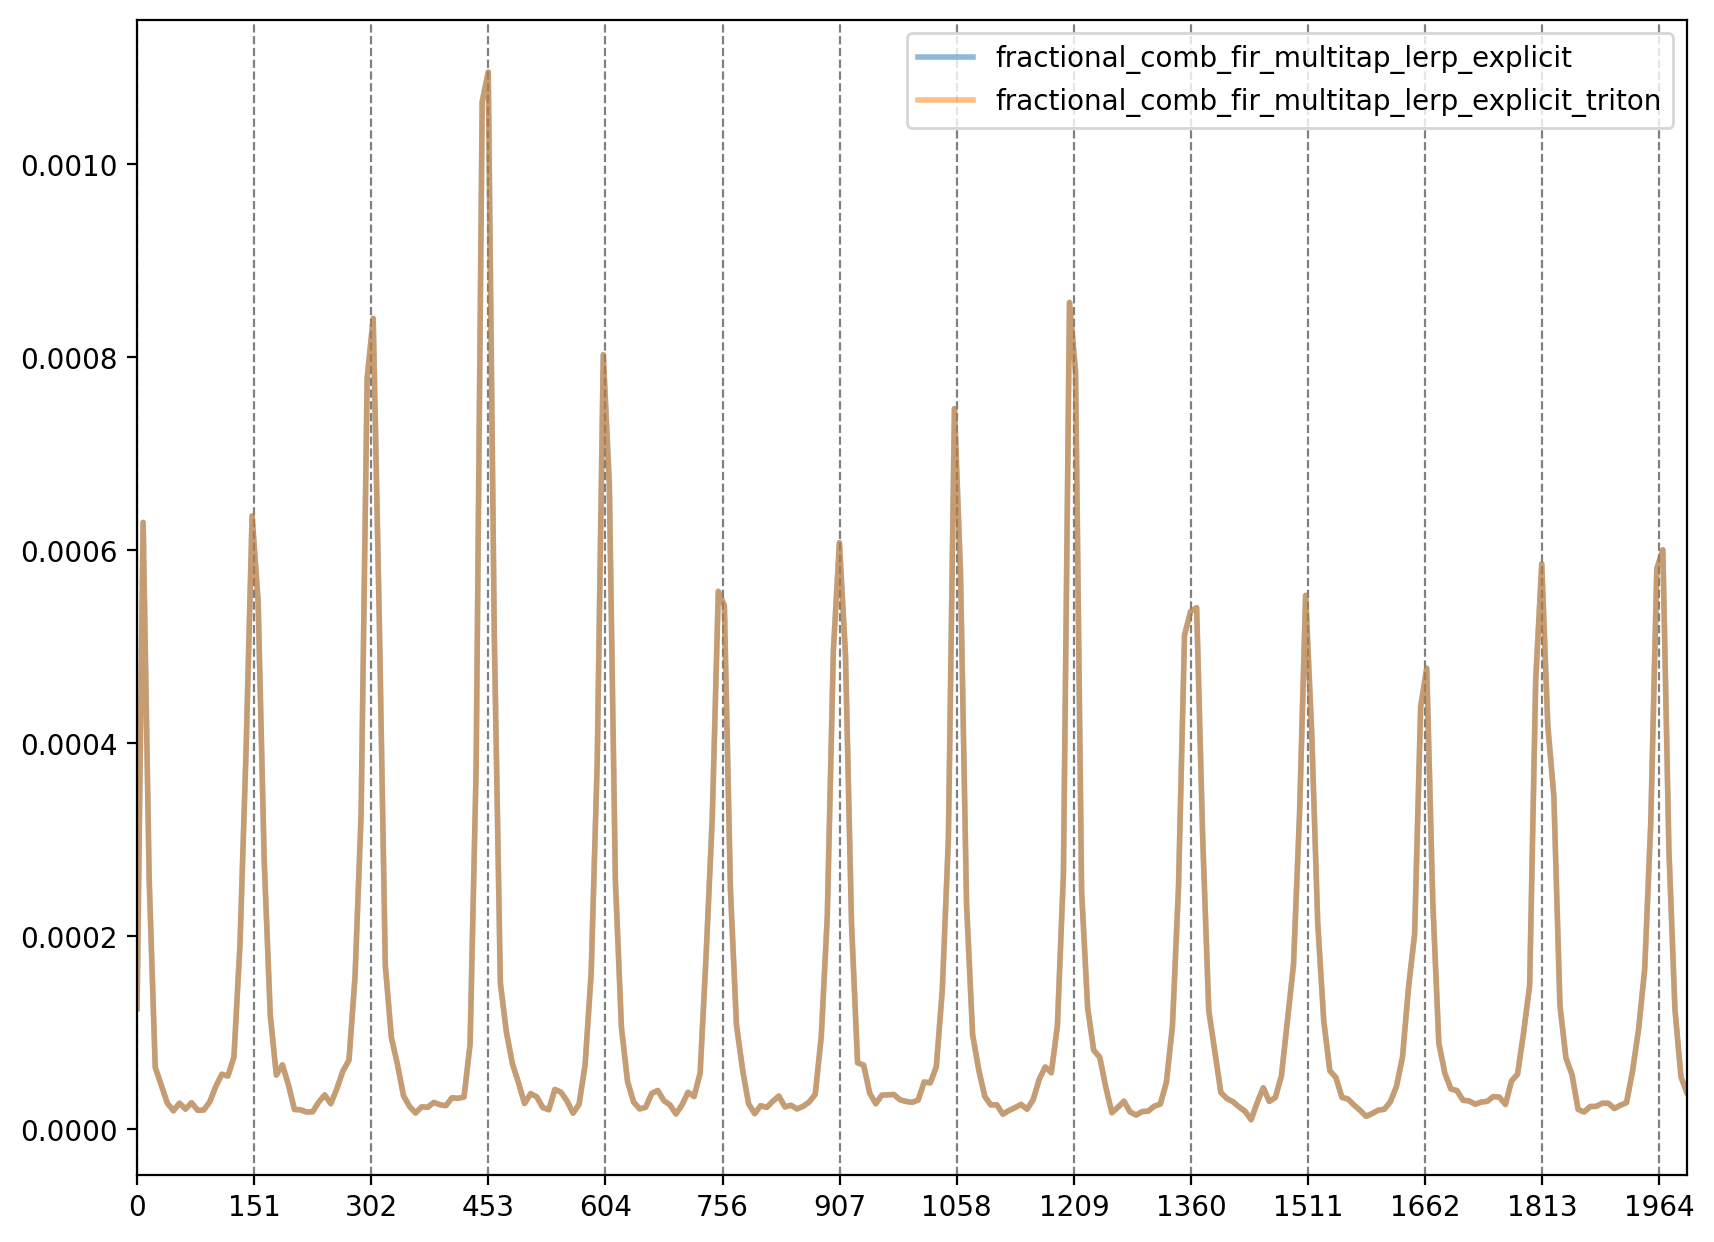

In [19]:
# Input to apply this on
sr = 16000
x = torch.randn(sr).unsqueeze(0)
device = torch.device('cuda:0')
# x = zeros( sr); x[0] = 1

# Try them all out
f0,a = 151.1, .75
# f0,a = 551.1, .75
# f0,a = 550, .75
# f0,a = 500, .75

# f0 = torch.tensor([[151.1]], requires_grad=True, device=device)

x = x.to(device)

candidates = [
    # combnet.filters.single_fractional_comb_fiir,
    # combnet.filters.single_fractional_comb_iir_faithful,
    # combnet.filters.single_comb_iir_faithful,
    # combnet.filters.single_comb_iir_fast,
    # combnet.filters.single_comb_fir,
    # combnet.filters.single_comb_fir_multitap,
    # combnet.filters.single_fractional_comb_diric,
    # combnet.filters.single_fractional_comb_modulo,
    
    # combnet.filters.single_fractional_comb_fir_multitap,
    # combnet.filters.fractional_comb_fir_multitap,
    # combnet.filters.fractional_comb_fir_multitap_pseudo_sparse,
    # combnet.filters.fractional_comb_fir_multitap_sparse,
    # combnet.filters.fractional_comb_fir_multitap_sparse_triton,
    # combnet.filters.fractional_comb_fir_multitap_sparse_lowmem,
    # combnet.filters.fractional_comb_fir_multitap_sparse_lowmem_convloop,
    # combnet.filters.fractional_comb_fir_multitap_sparse_lowmem_explicit,
    
    # combnet.filters.single_fractional_comb_fir_lerp,
    # combnet.filters.single_fractional_comb_fir_multitap_lerp,
    # combnet.filters.fractional_comb_fir_multitap_lerp,
    combnet.filters.fractional_comb_fir_multitap_lerp_explicit,
    combnet.filters.fractional_comb_fir_multitap_lerp_explicit_triton,
]

for comb_fn in candidates:
    y = comb_fn( x, f0, a, sr)
    if isinstance(y, tuple):
        y, y1 = y
        y1 = y1.squeeze()
        gca().plot( *welch( y1/y1.std(), fs=sr, nperseg=1024*2, nfft=2048), label=comb_fn.__name__ + '_y1', alpha=.5, lw=2)
    y = y.squeeze().cpu()
    gca().plot( *welch( y/y.std(), fs=sr, nperseg=1024*2, nfft=2048), label=comb_fn.__name__, alpha=.5, lw=2)


gcf().set_size_inches(10, 7.5)
gca().set_xticks(torch.arange( 0, sr//2, f0))
gca().xaxis.grid(True, linestyle='--', color='gray')
# gca().set_yscale('log')
gca().legend()
gca().set_xlim(0, 2000)
# torchviz.make_dot(y, {'f0': f0})

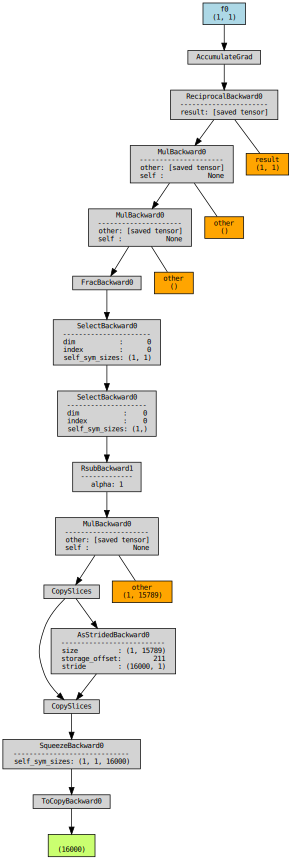

In [95]:
# Input to apply this on
sr = 16000
x = torch.randn(sr).unsqueeze(0)
device = torch.device('cuda:0')
# x = zeros( sr); x[0] = 1

# Try them all out
f0,a = 151.1, .75
# f0,a = 551.1, .75
# f0,a = 550, .75
# f0,a = 500, .75

f0 = torch.tensor([[151.1]], requires_grad=True, device=device)

x = x.to(device)

comb_fn = combnet.filters.fractional_comb_fir_multitap_lerp

y = comb_fn( x, f0, a, sr)
# if isinstance(y, tuple):
#     y, y1 = y
#     y1 = y1.squeeze()
#     gca().plot( *welch( y1/y1.std(), fs=sr, nperseg=1024*2, nfft=2048), label=comb_fn.__name__ + '_y1', alpha=.5, lw=2)
y = y.squeeze().cpu()
# gca().plot( *welch( y/y.std(), fs=sr, nperseg=1024*2, nfft=2048), label=comb_fn.__name__, alpha=.5, lw=2)


# gcf().set_size_inches(10, 7.5)
# gca().set_xticks(torch.arange( 0, sr//2, f0))
# gca().xaxis.grid(True, linestyle='--', color='gray')
# # gca().set_yscale('log')
# gca().legend()
# gca().set_xlim(0, 2000)
torchviz.make_dot(y, {'f0': f0}, show_attrs=True, show_saved=True)

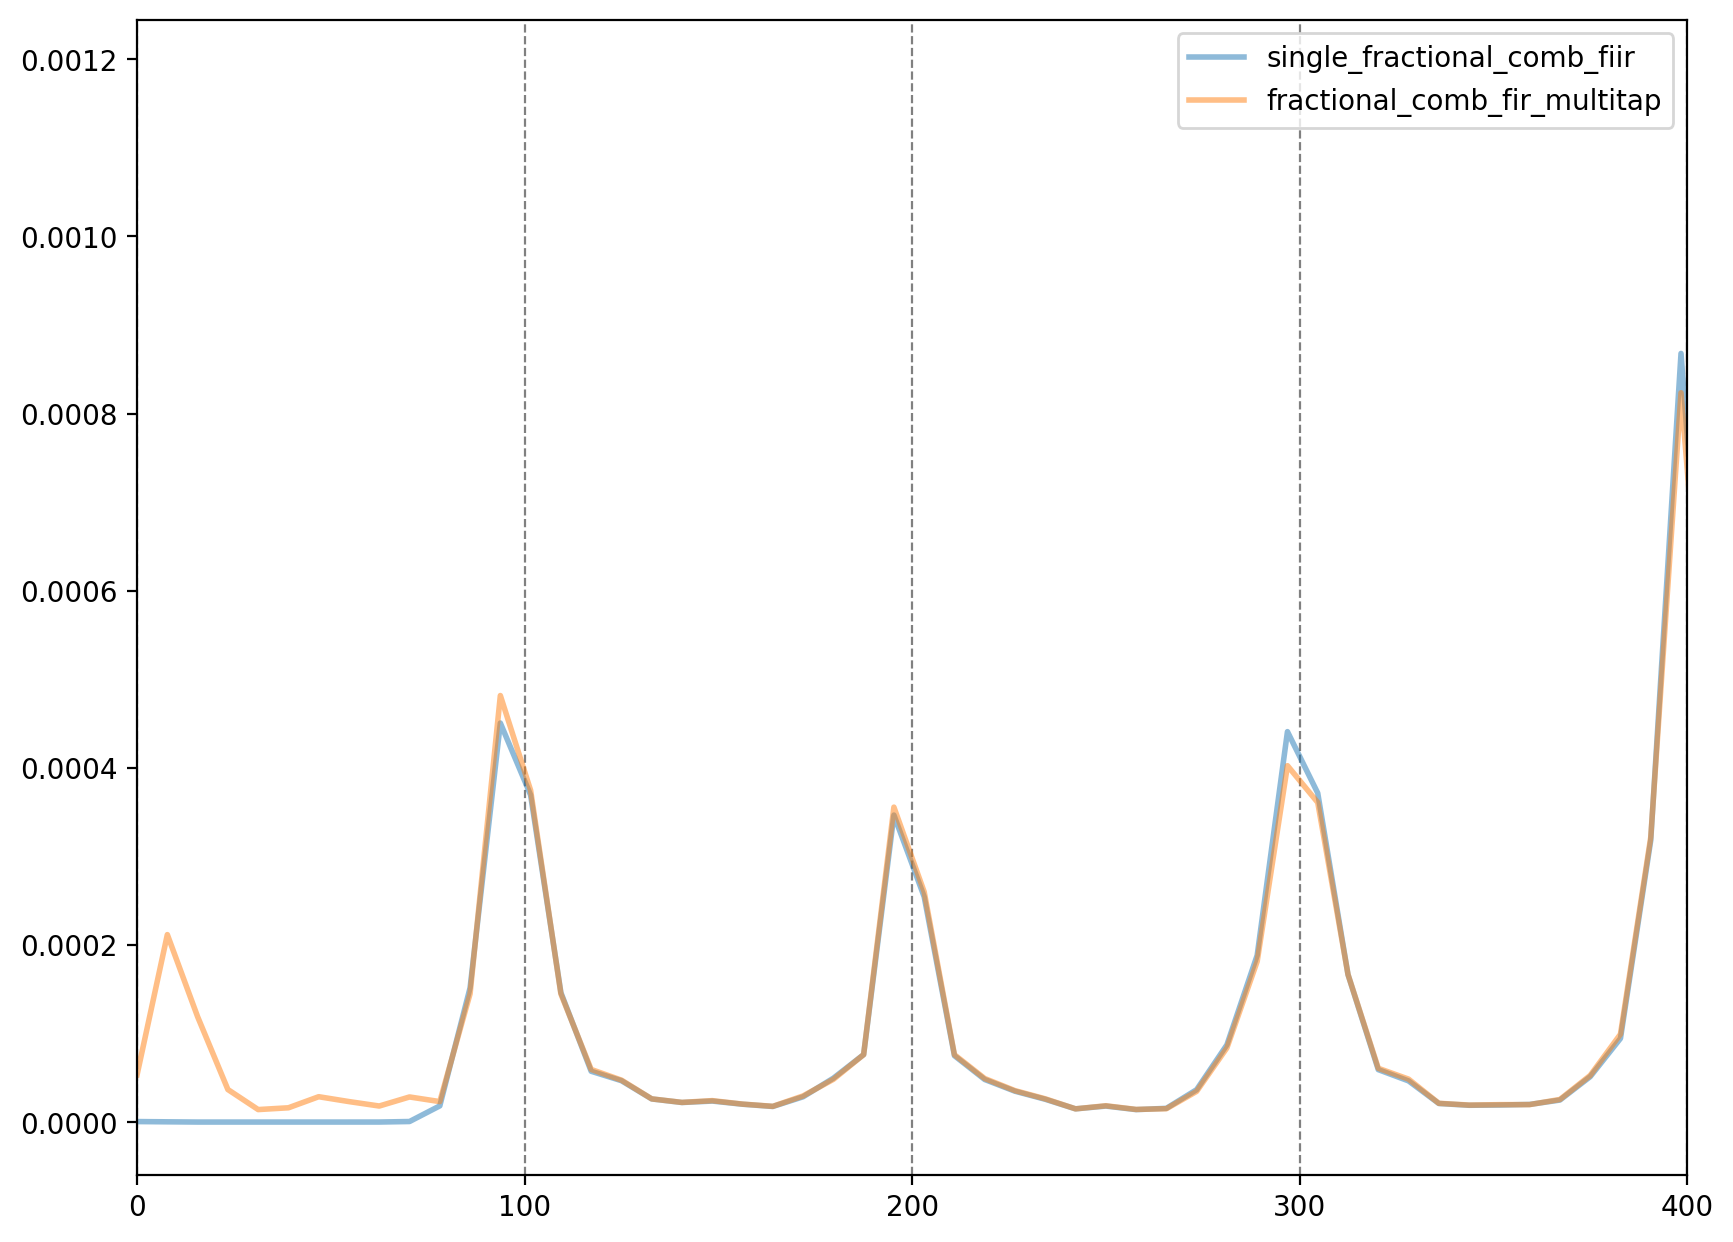

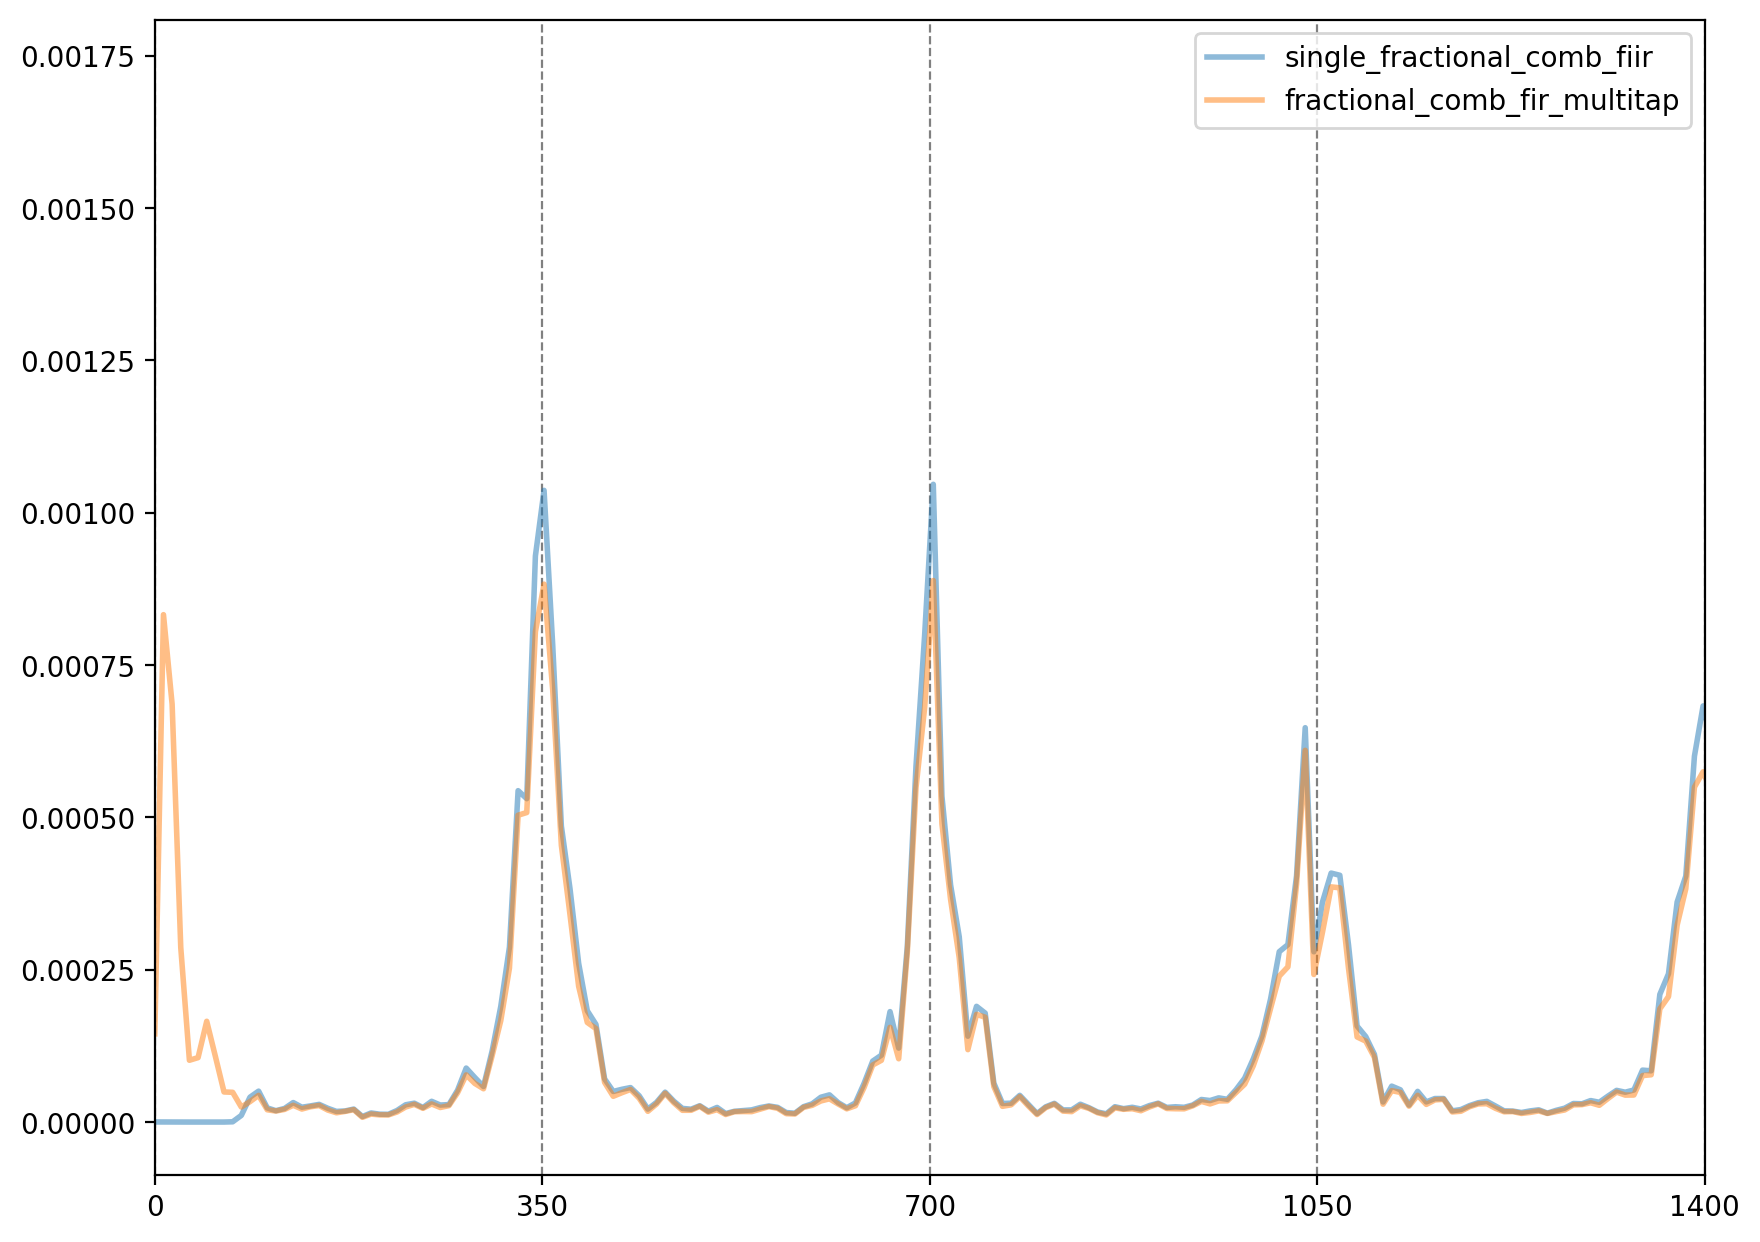

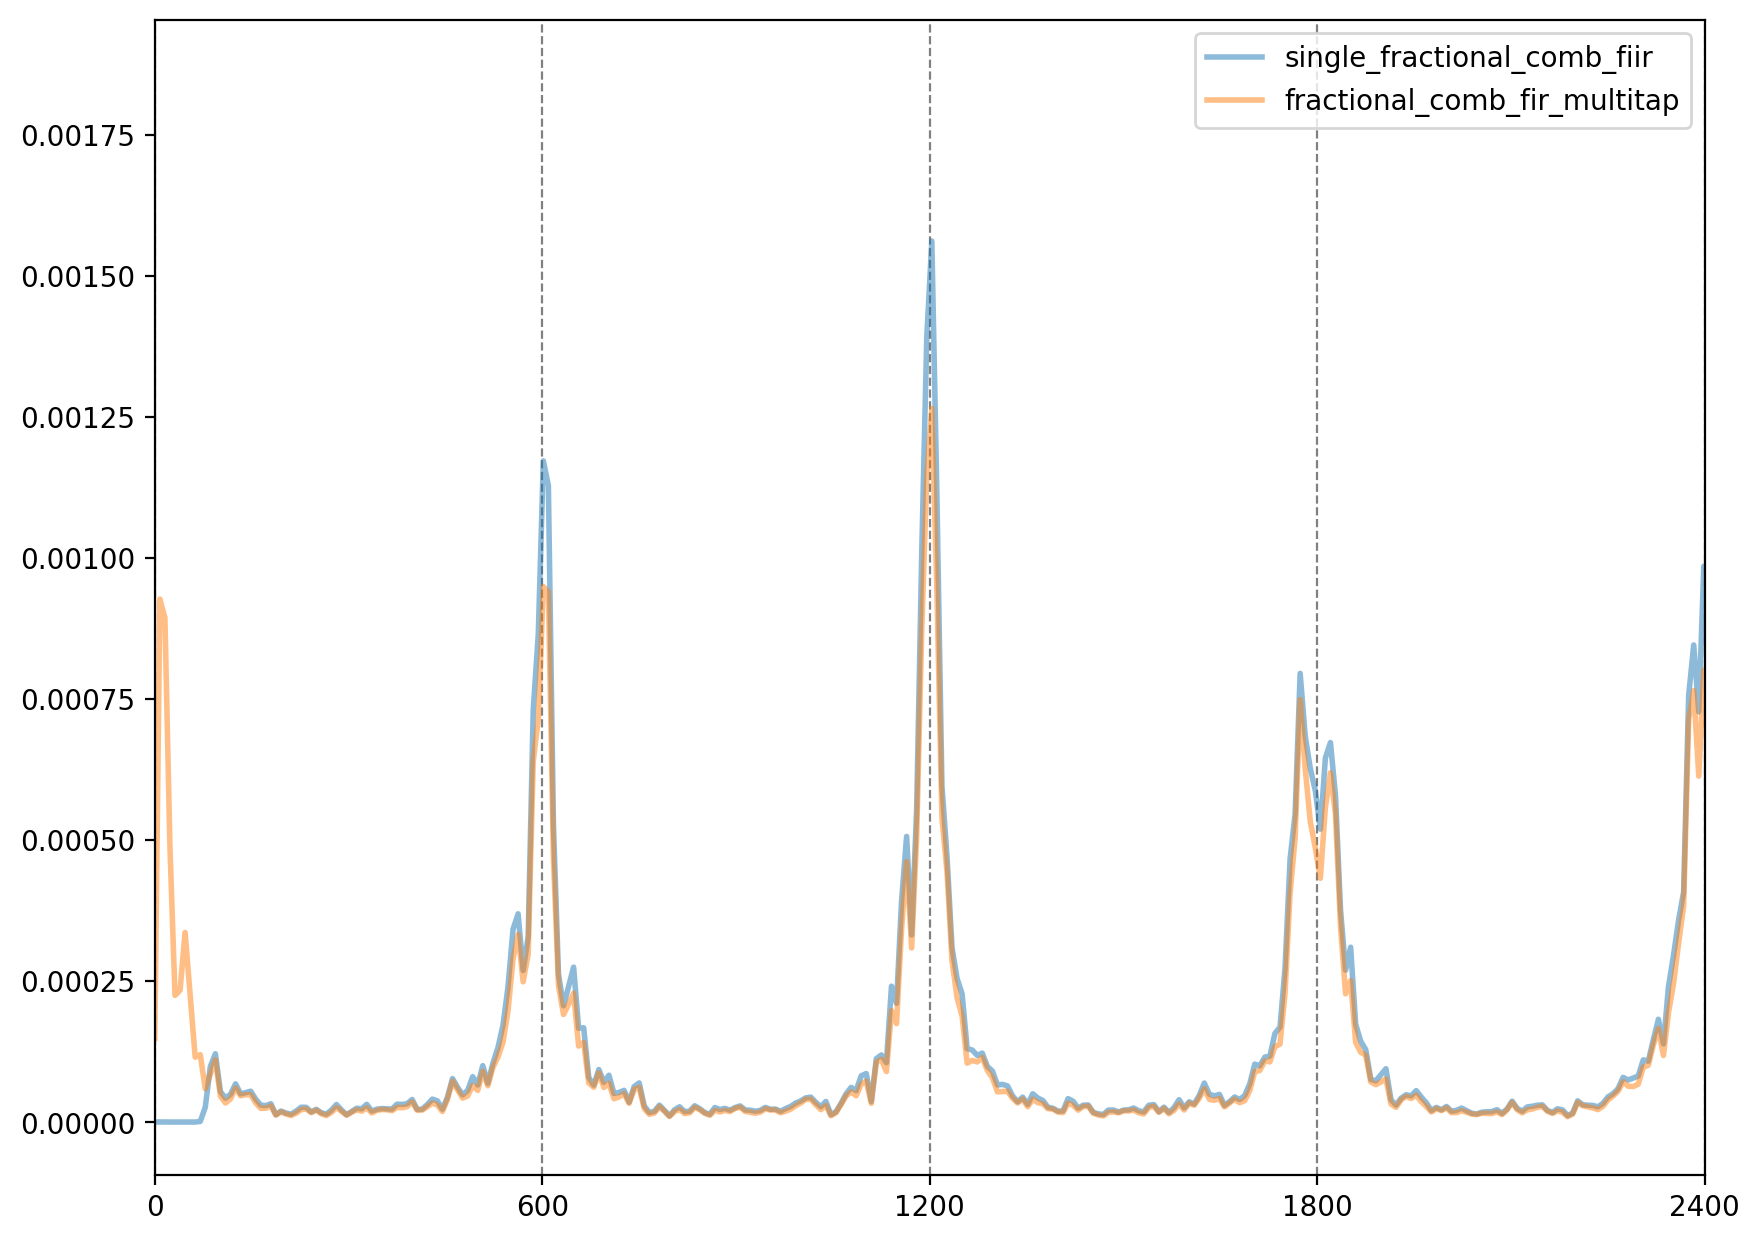

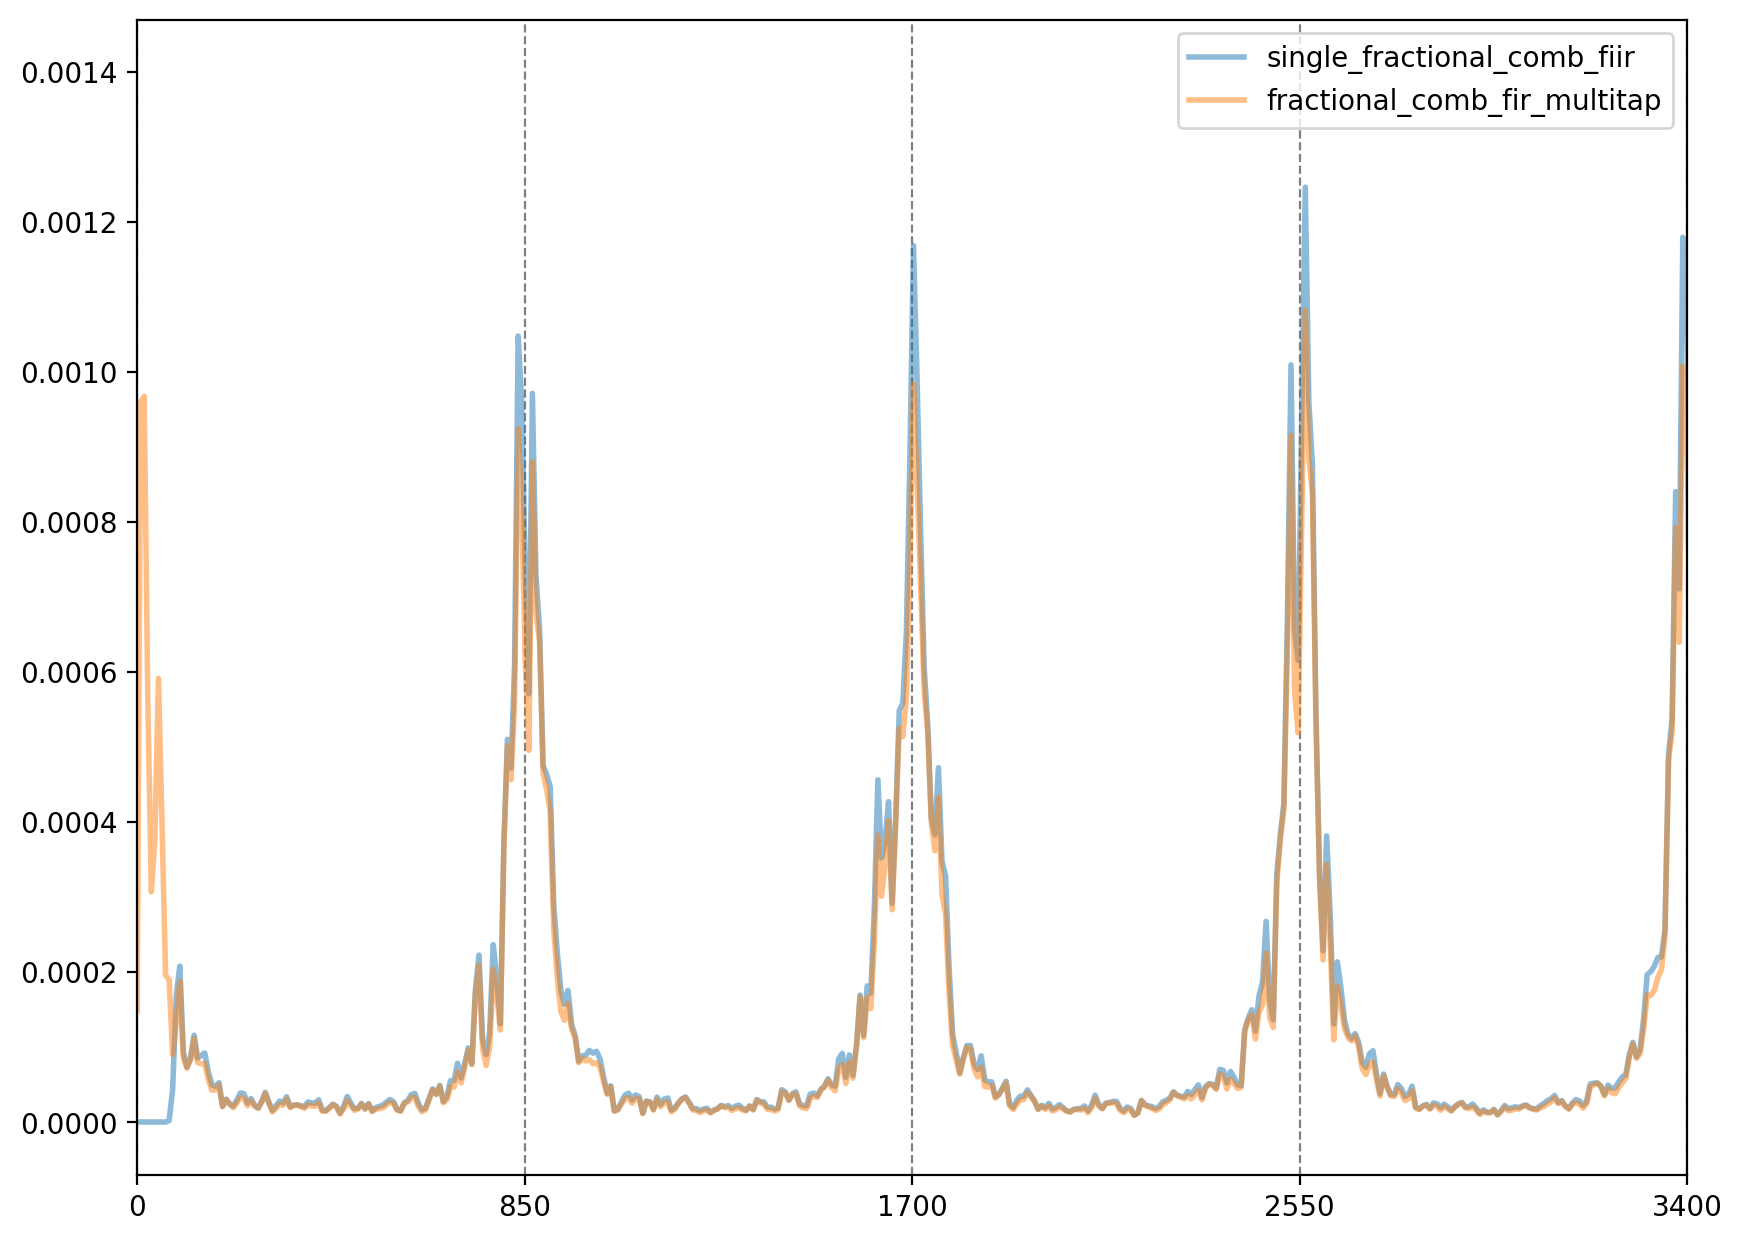

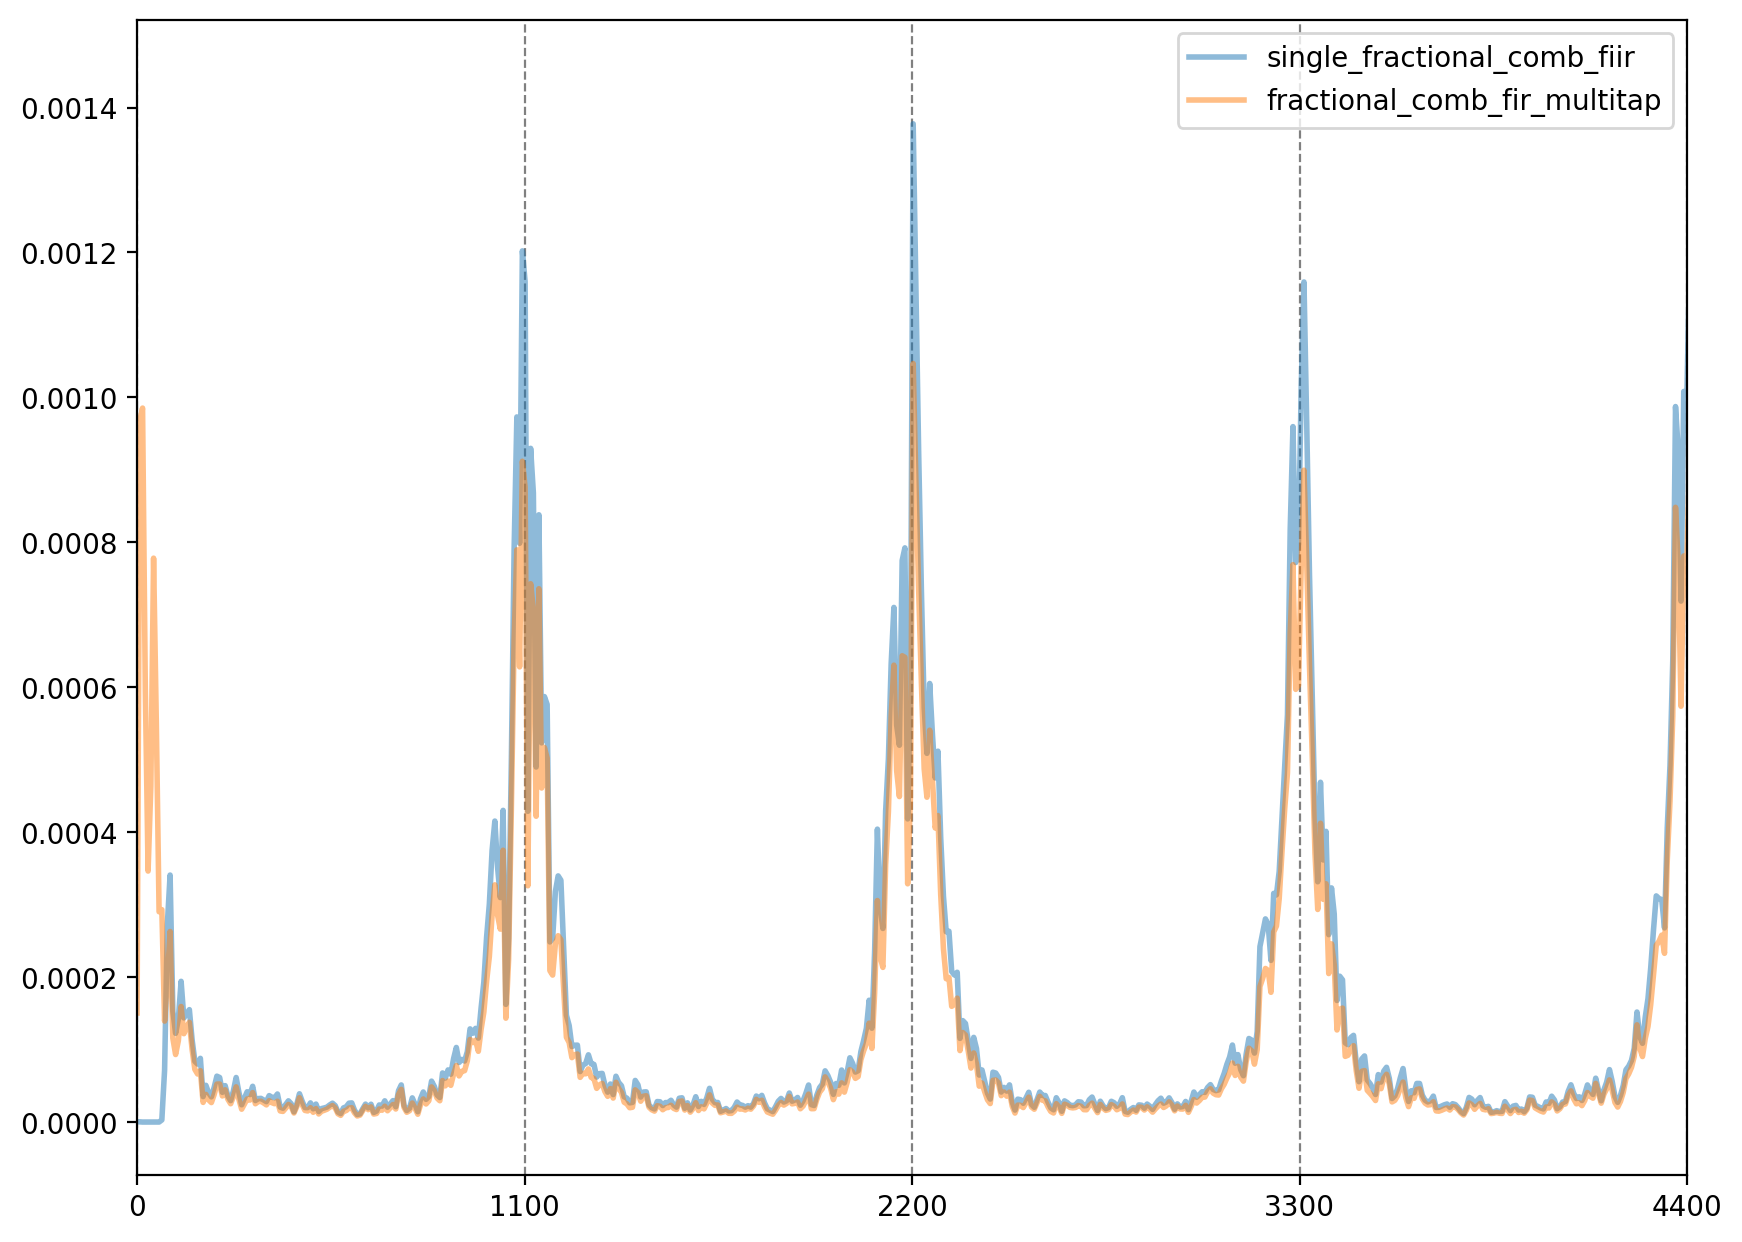

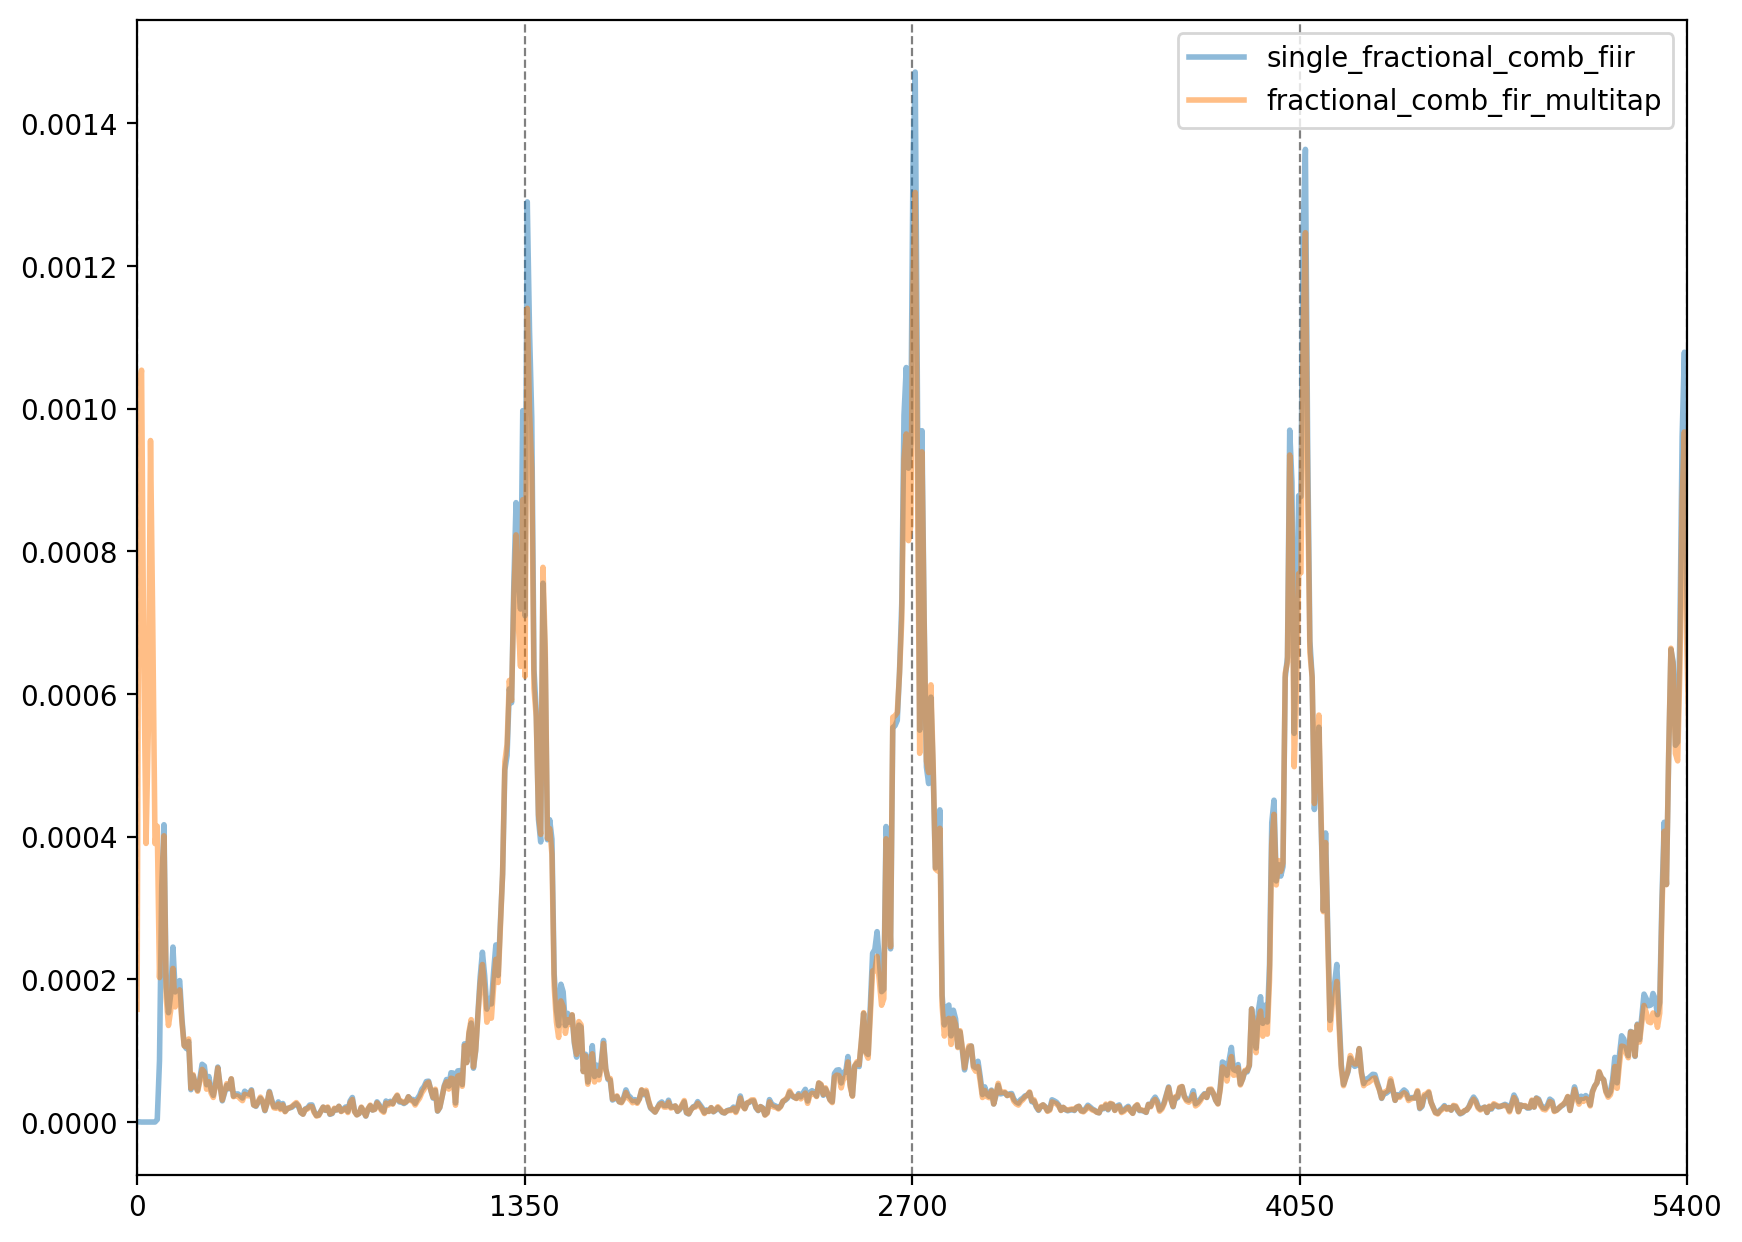

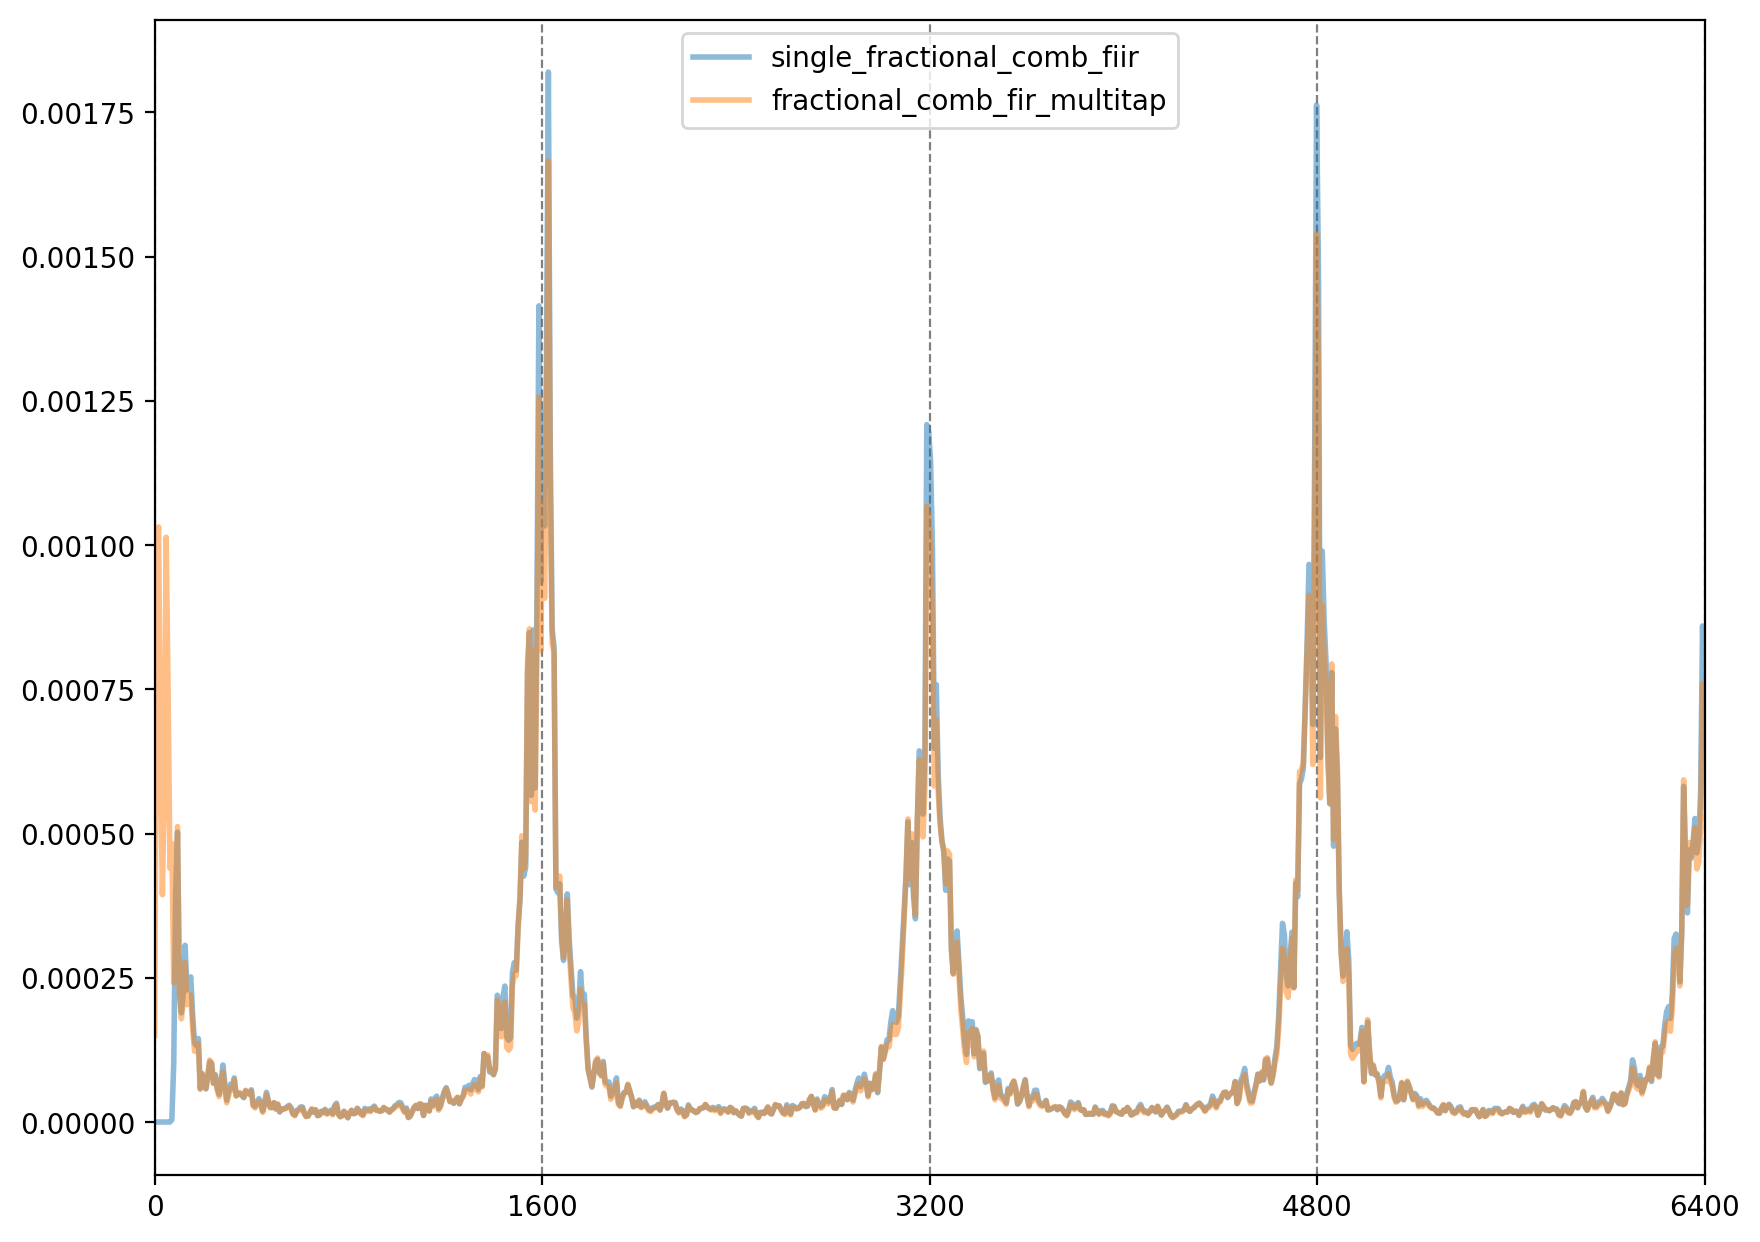

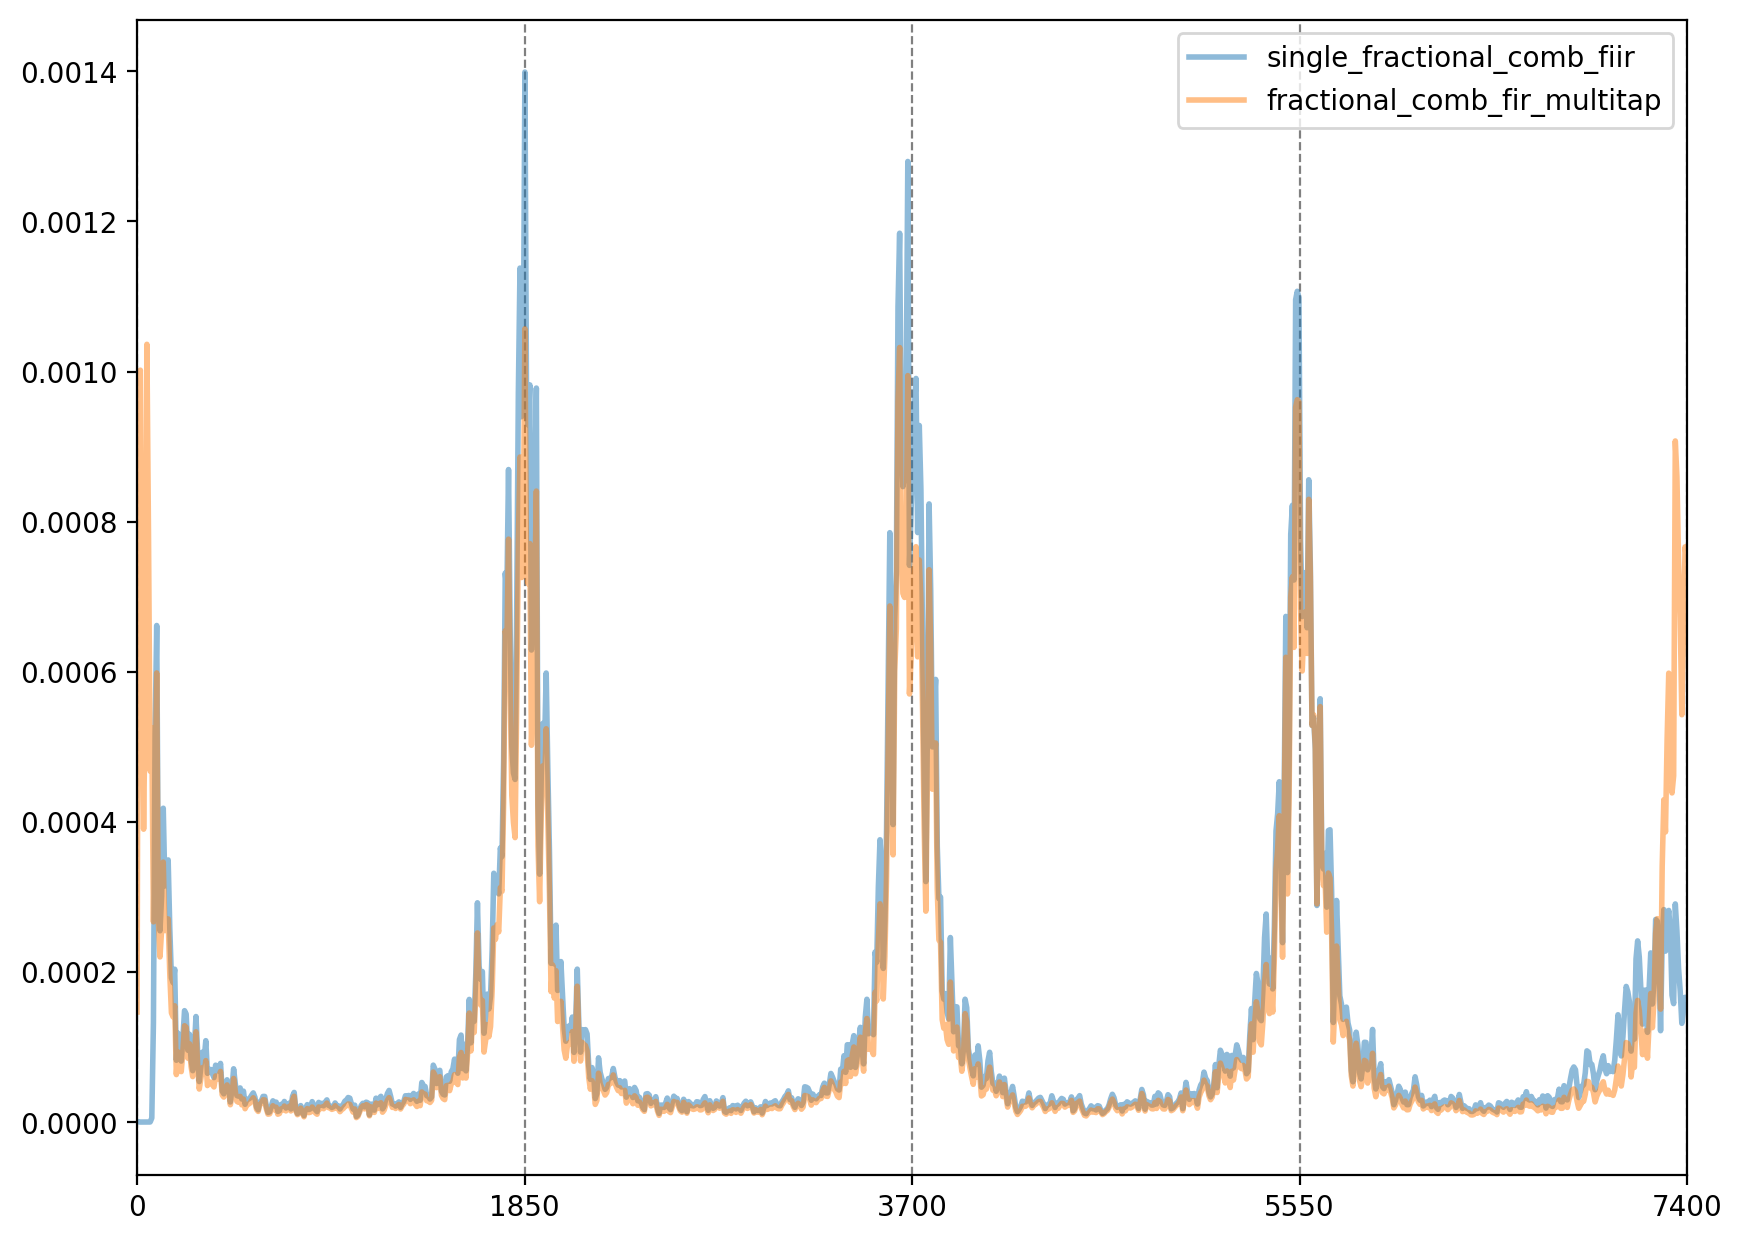

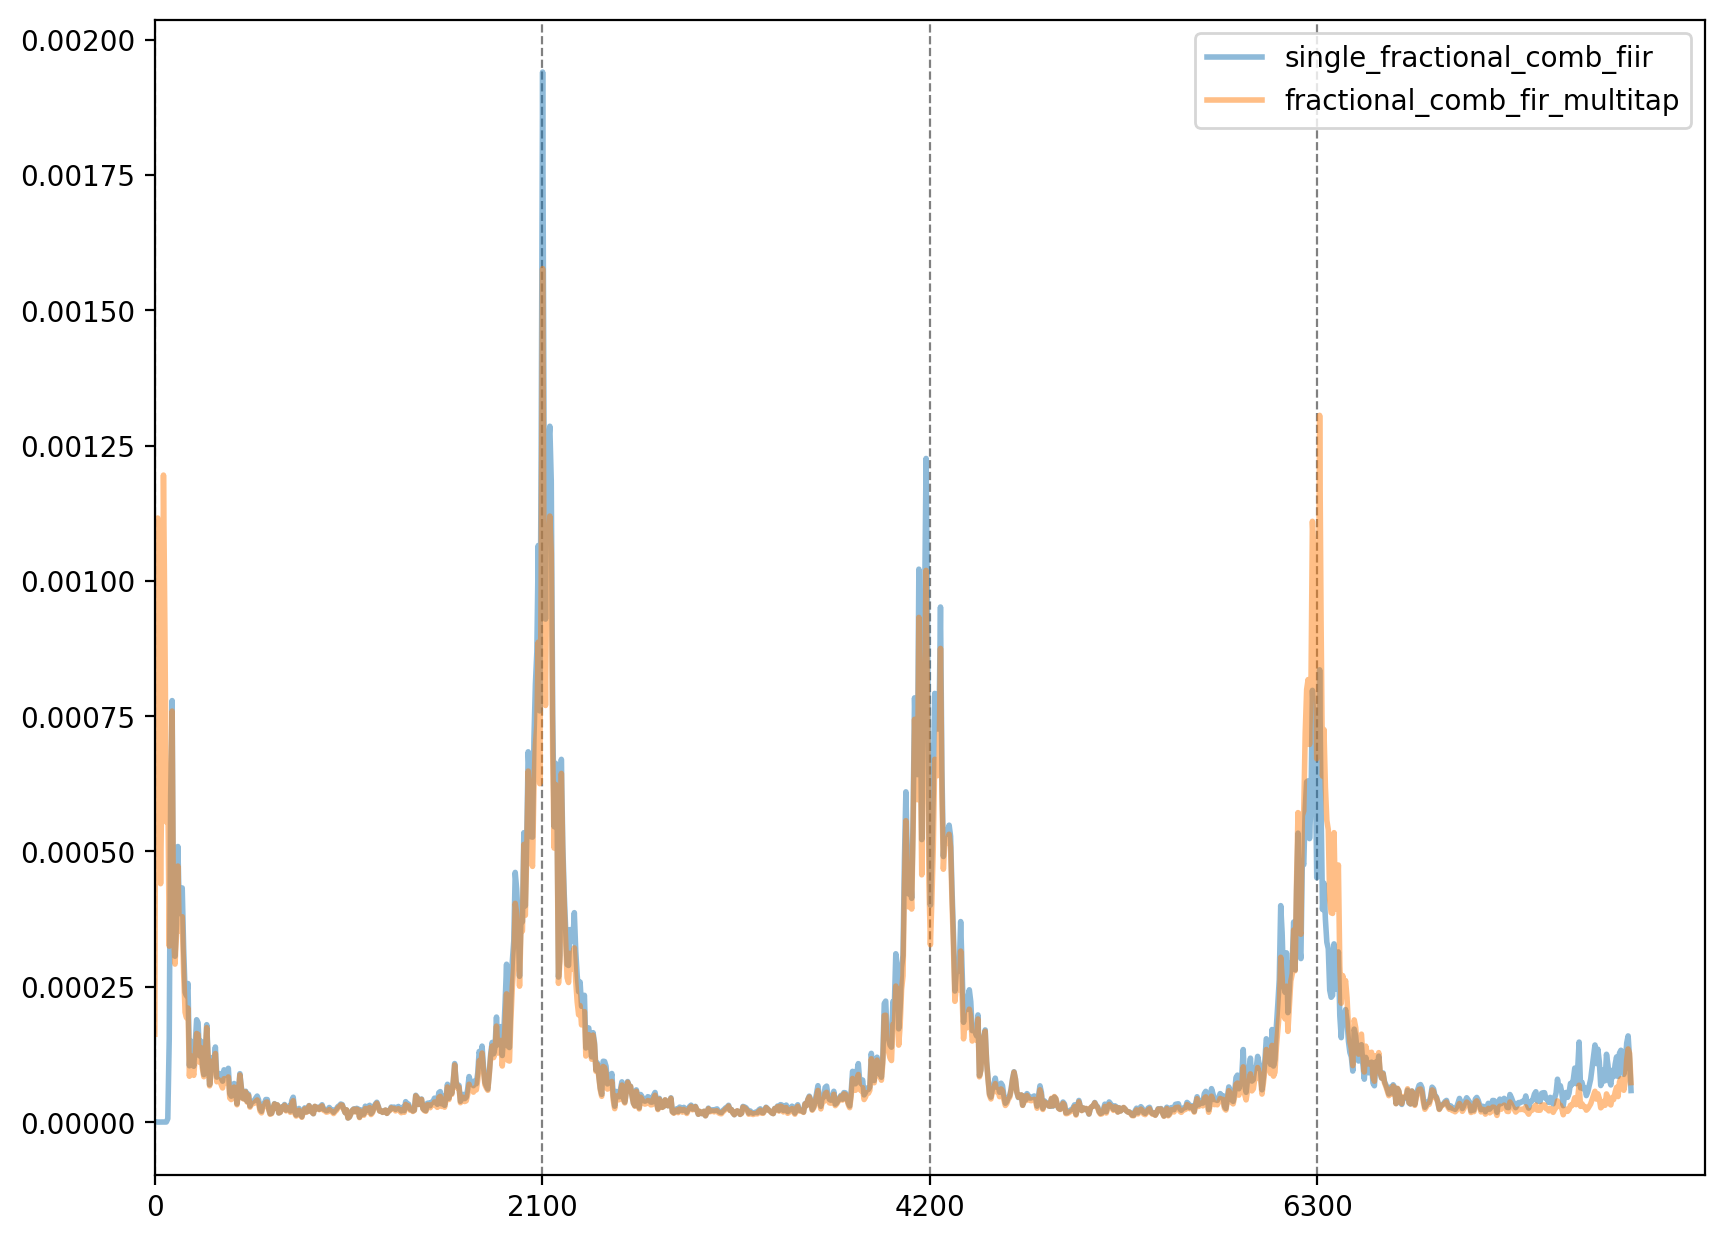

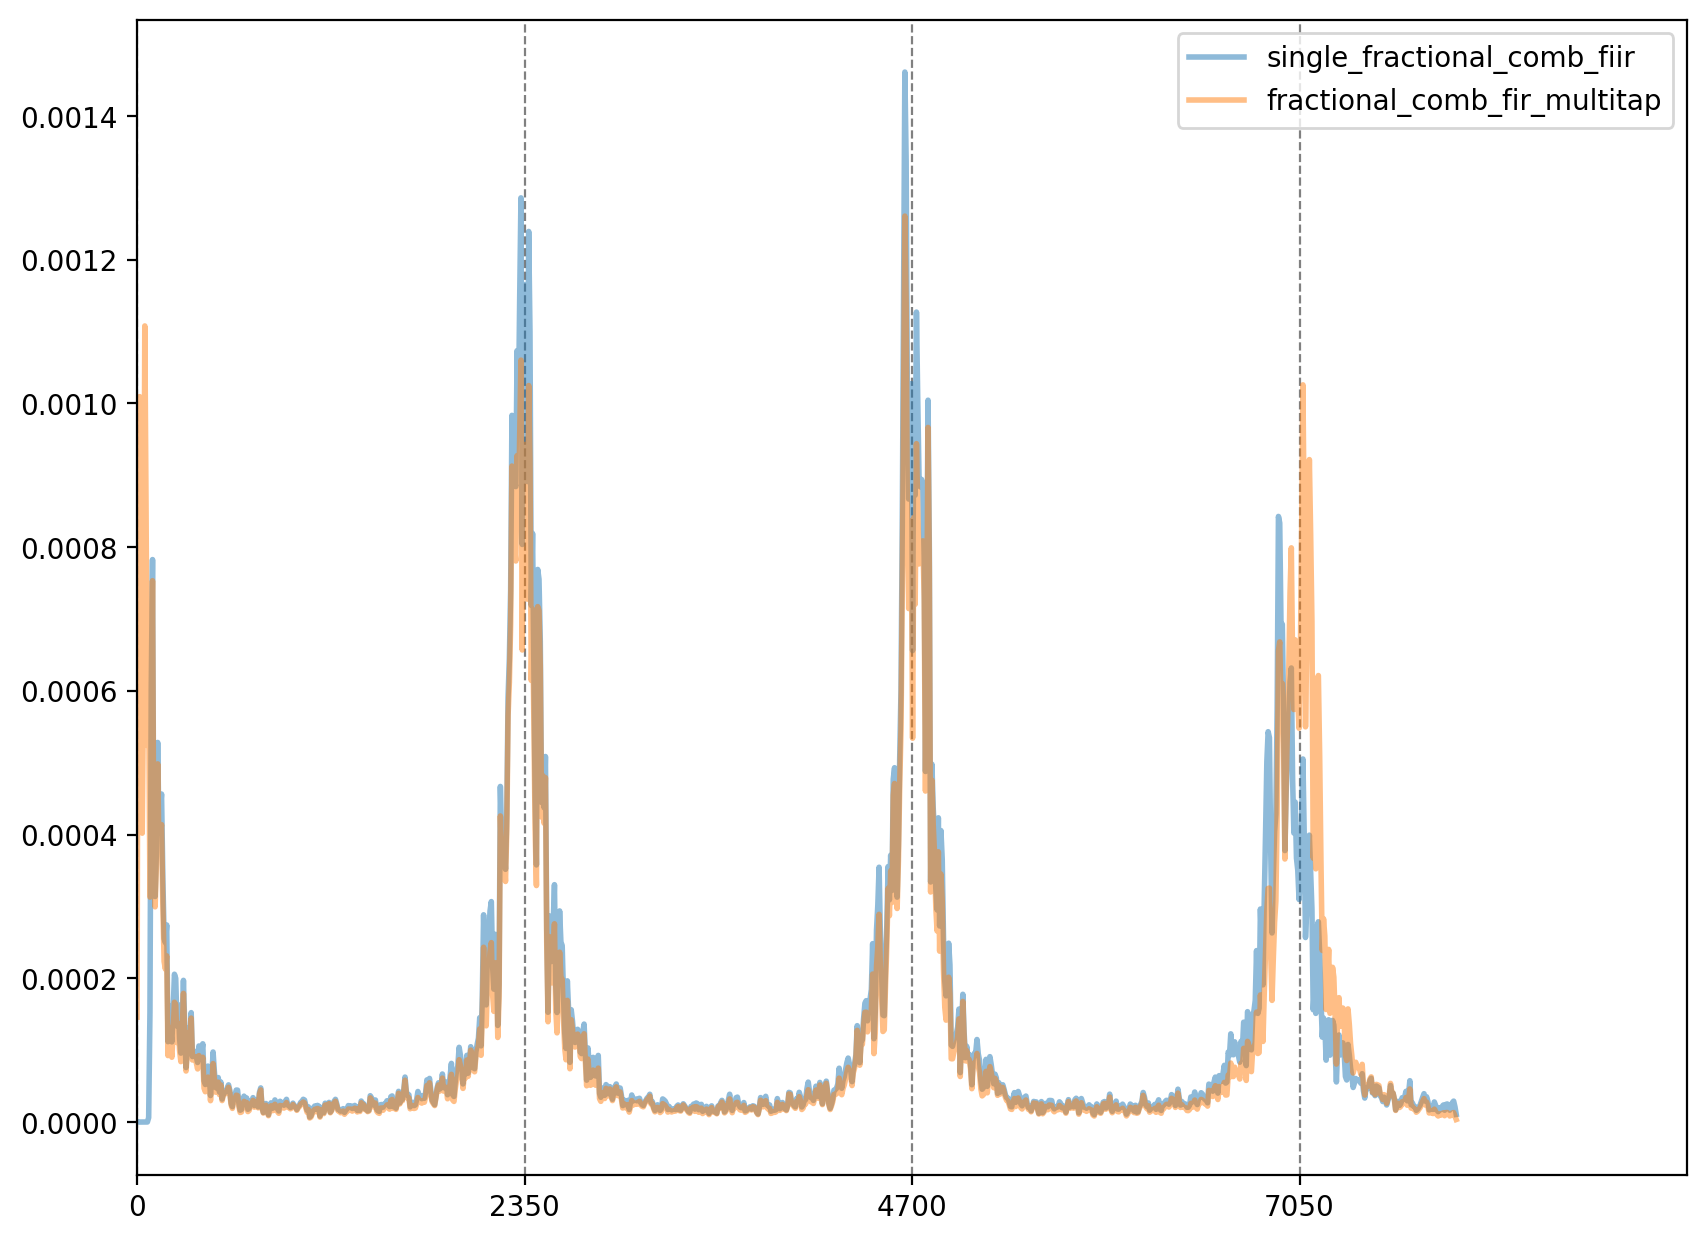

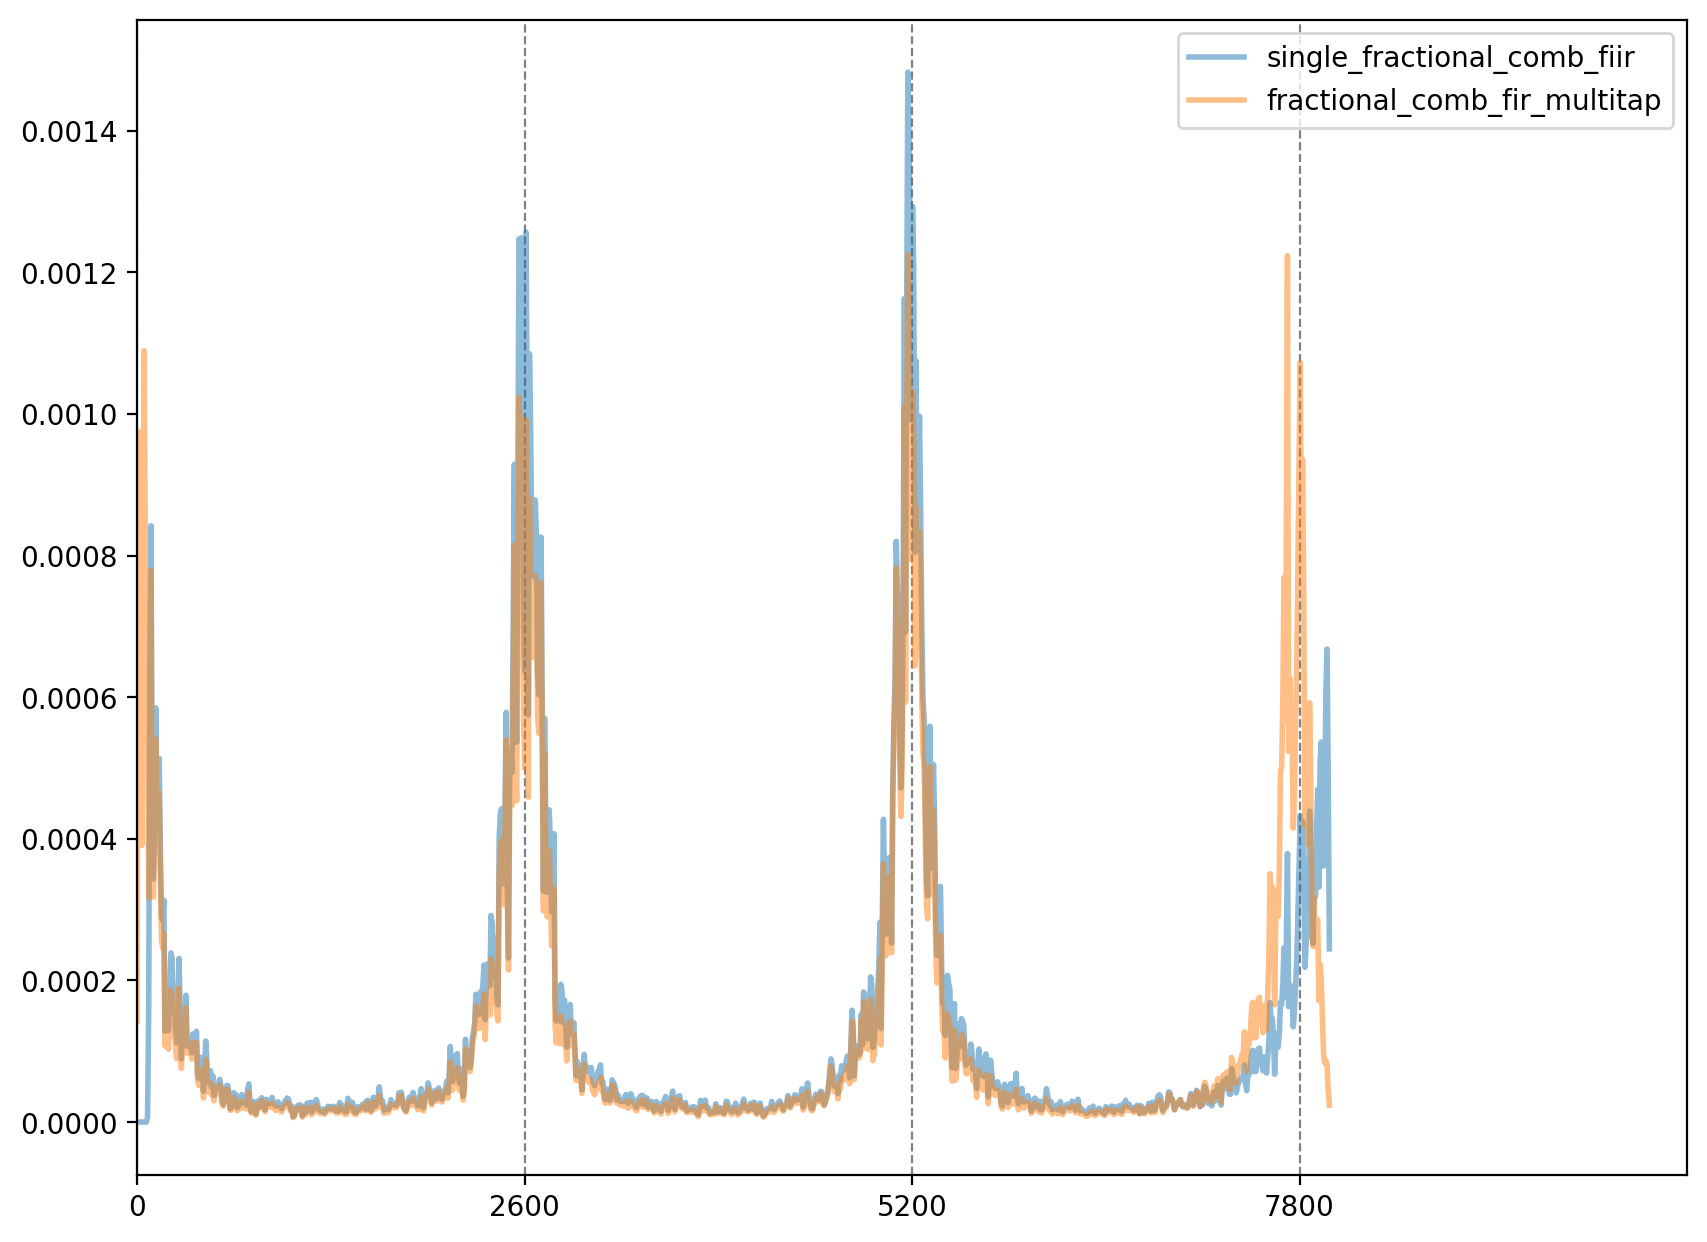

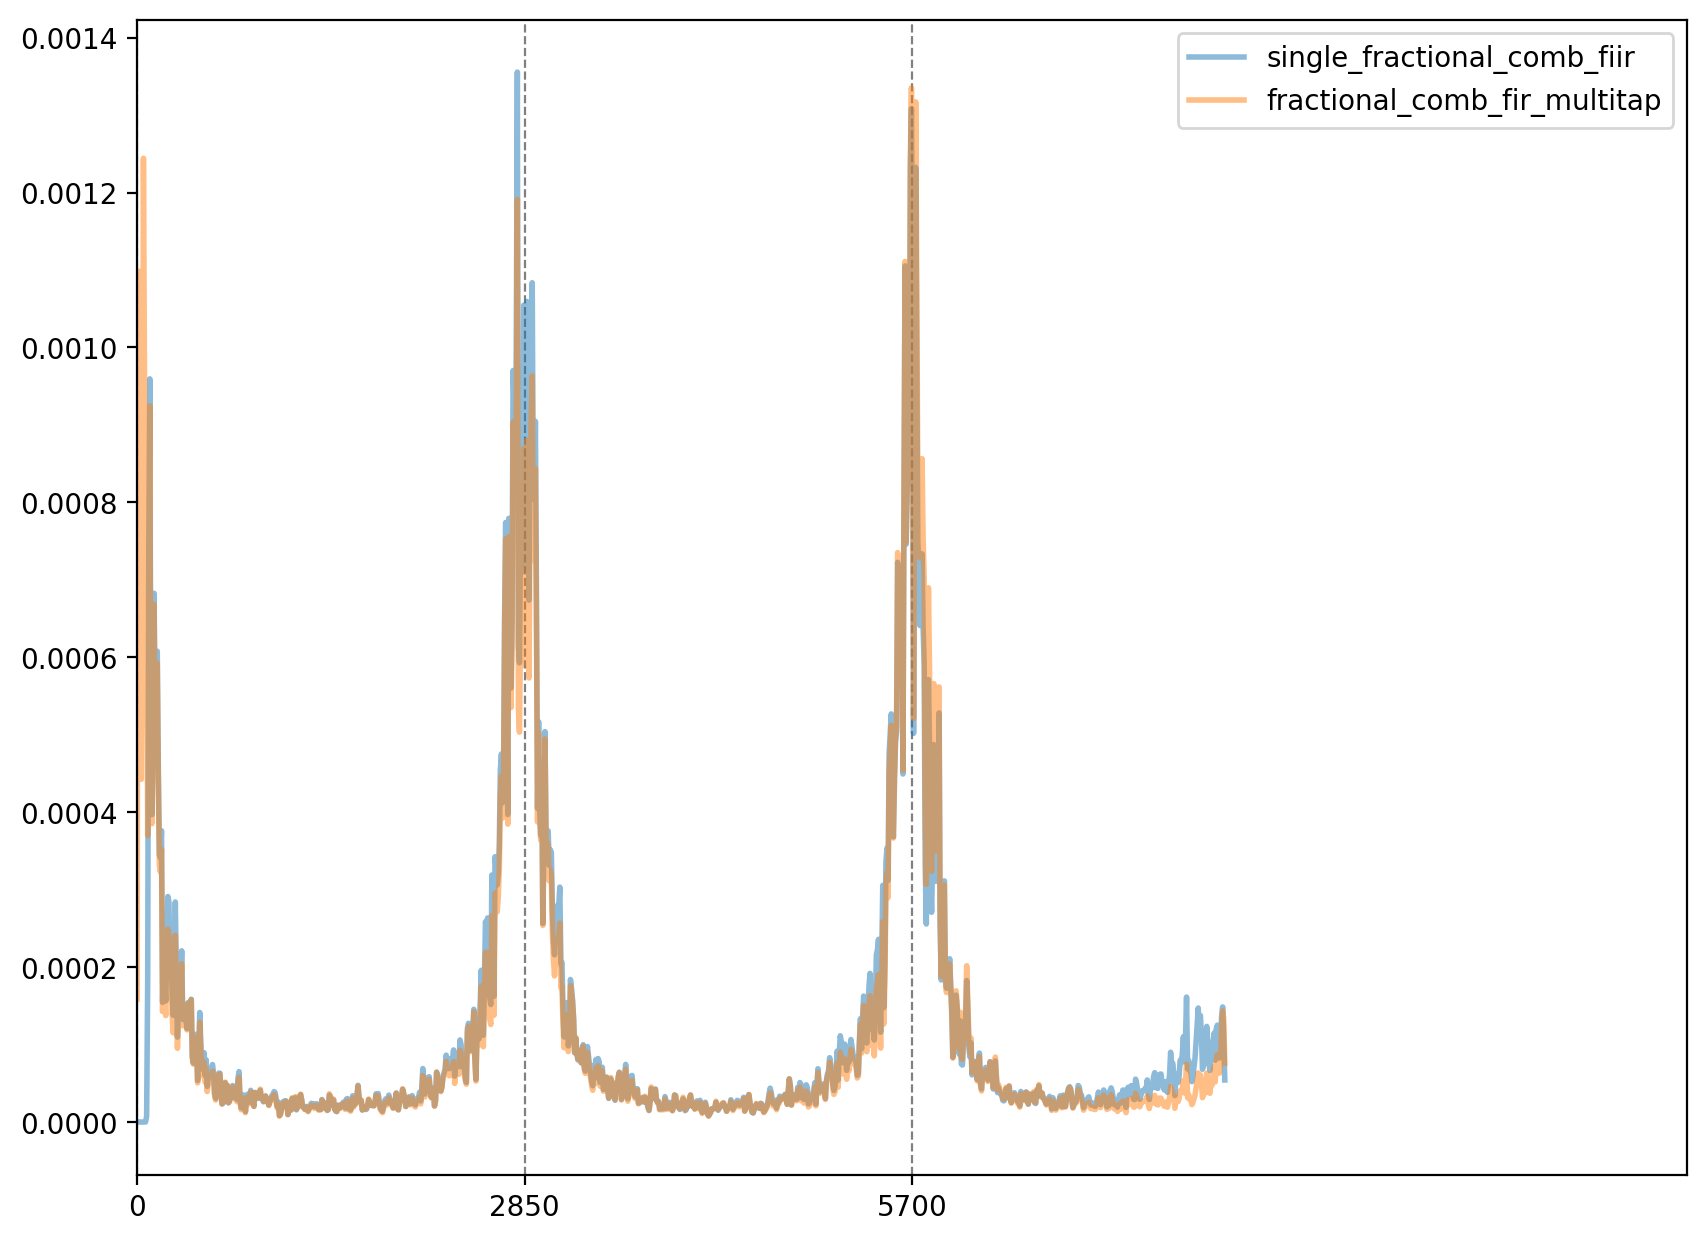

In [21]:
# Input to apply this on
sr = 16000
x = torch.randn(sr).unsqueeze(0)
# x = zeros( sr); x[0] = 1

# Try them all out
f0,a = 151.1, .75
f0,a = 551.1, .75

candidates = [
    # combnet.filters.single_comb_iir_faithful,
    # combnet.filters.single_comb_fir_multitap,
    combnet.filters.single_fractional_comb_fiir,
    # combnet.filters.single_fractional_comb_modulo,
    # combnet.filters.single_fractional_comb_diric
    # combnet.filters.single_fractional_comb_fir_multitap
    combnet.filters.fractional_comb_fir_multitap
]

for f0 in range(100, 3000, 250):
    for comb_fn in candidates:
        y = comb_fn( x, f0, a, sr).squeeze()
        gca().plot( *welch( y/y.std(), fs=sr, nperseg=1024*2, nfft=2048), label=comb_fn.__name__, alpha=.5, lw=2)

    gcf().set_size_inches(10, 7.5)
    gca().set_xticks(torch.arange( 0, sr//2, f0))
    gca().xaxis.grid(True, linestyle='--', color='gray')
    # gca().set_yscale('log')
    gca().legend()
    gca().set_xlim(0, int(4*f0))
    plt.show()

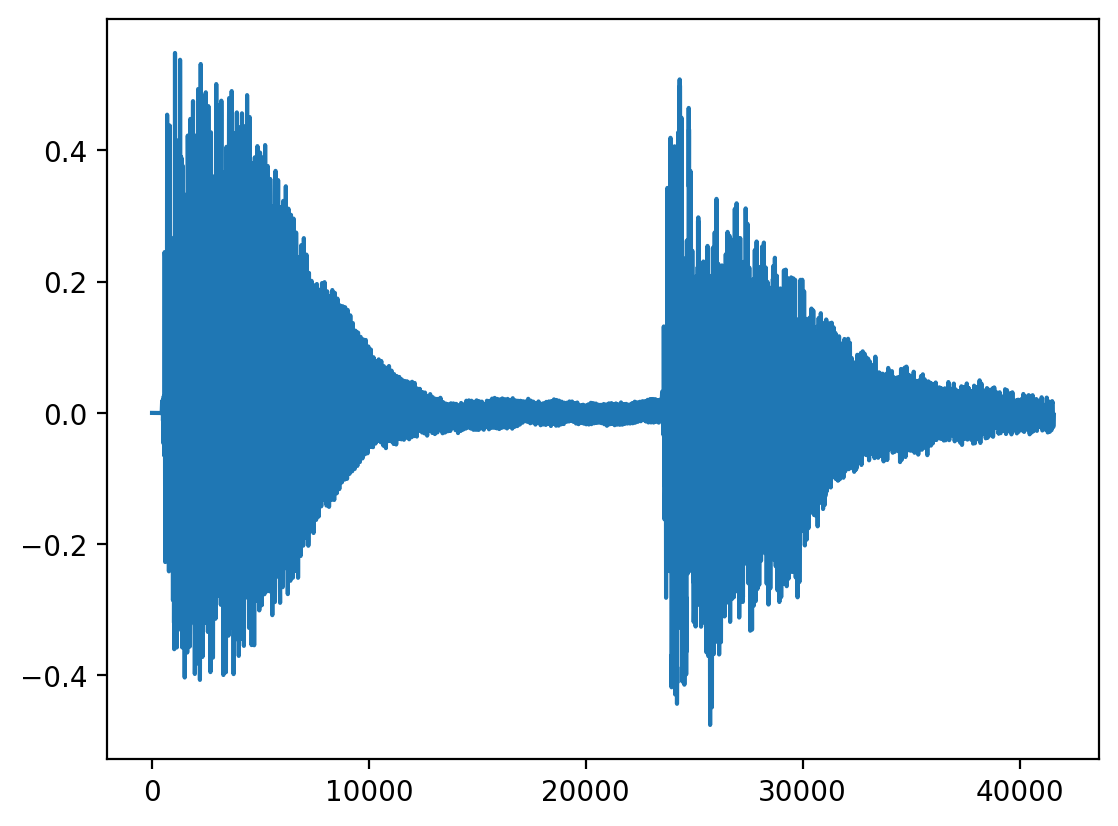

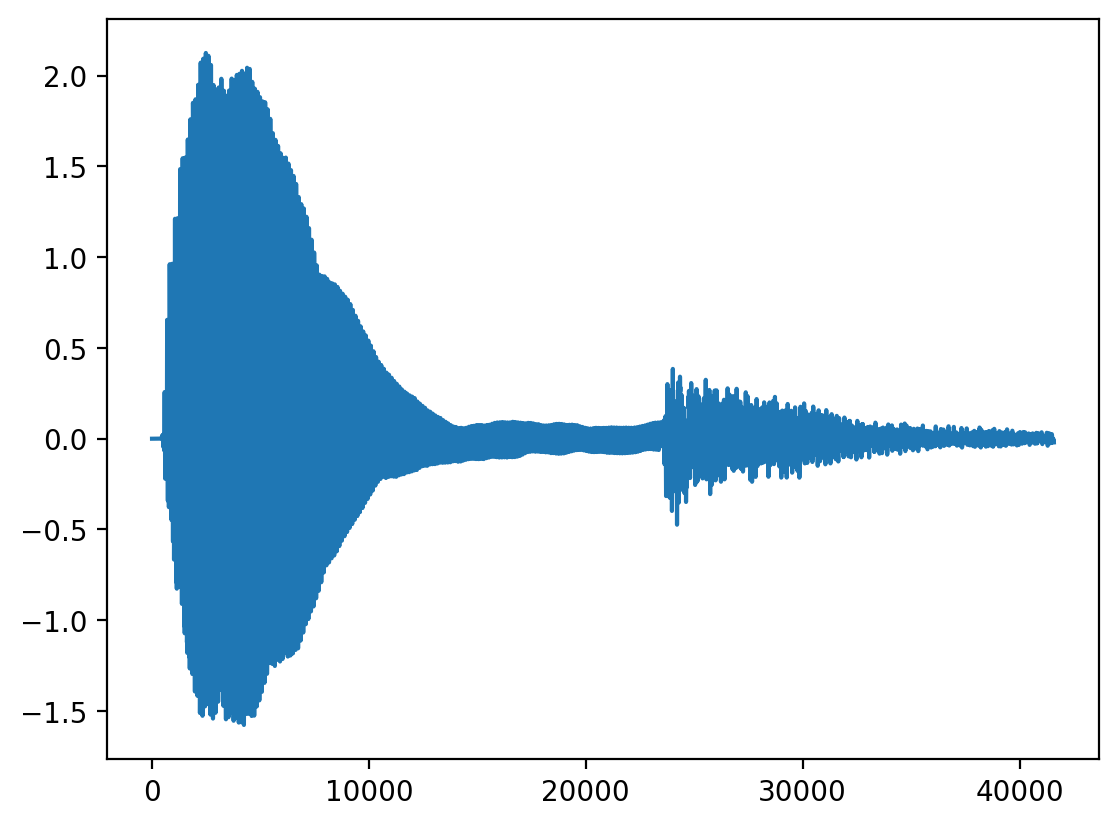

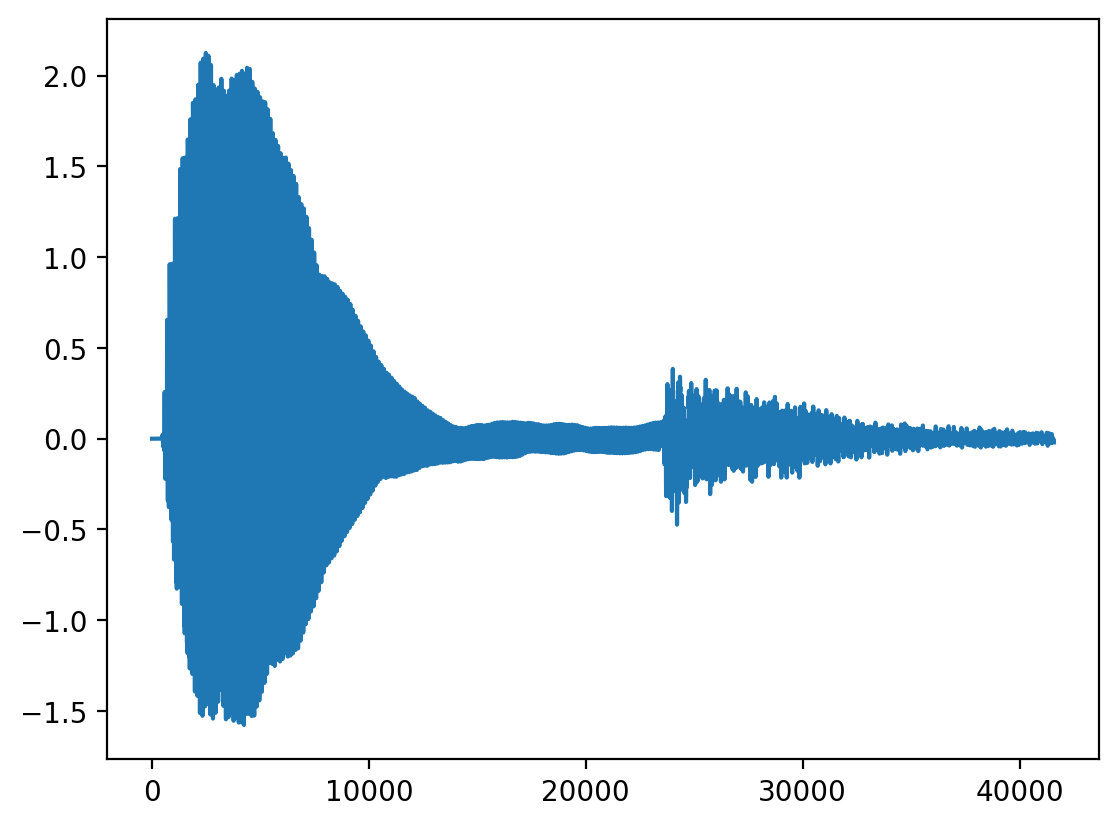

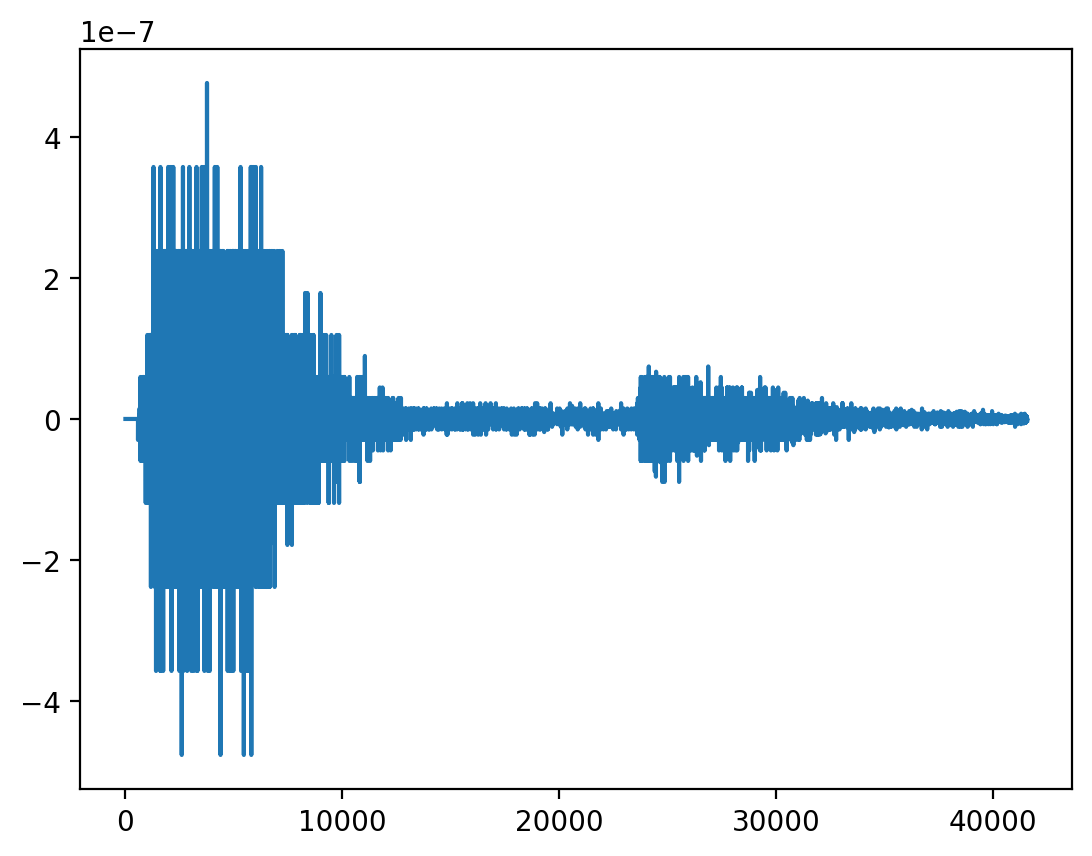

In [20]:
x, sr = torchaudio.load('tri.wav')
f0 = 371.
a = 0.8

x = x.to('cuda:0')

z = combnet.filters.fractional_comb_fir_multitap_lerp_explicit(x, f0, a, sr).cpu()
w = z
y = z

w = combnet.filters.fractional_comb_fir_multitap_lerp_explicit_triton(x, f0, a, sr).cpu()
y = z - w
# w, y = combnet.filters.fractional_comb_fir_multitap_lerp_explicit_triton(x[None].repeat(2, 1, 1).contiguous(), f0, a, sr).cpu()

# w = combnet.filters.fractional_comb_fir_multitap_pseudo_sparse_debug(x, f0, a, sr)
# y = combnet.filters.fractional_comb_fir_multitap_sparse(x, f0, a, sr)

# w = combnet.filters.single_fractional_comb_fiir(x, f0, a, sr)
# y = combnet.filters.single_fractional_comb_iir_faithful(x, f0, a, sr)

plt.plot(x.squeeze().cpu()); plt.show()
plt.plot(z.squeeze()); plt.show()
plt.plot(w.squeeze()); plt.show()
plt.plot(y.squeeze()); plt.show()

soundsc(x.squeeze().cpu(), sr)
soundsc(z.squeeze(), sr)
soundsc(w.squeeze(), sr)
soundsc(y.squeeze(), sr)

In [ ]:
sr = 16000
from scipy.io.wavfile import read as wavread
from scipy.signal import resample_poly
srf,x = wavread( 'tri.wav')
print(srf)
x = x.astype( 'float32') / 33000
x = resample_poly( x, sr, srf)
x -= x.mean()
soundsc( x, sr)

device = torch.device('cuda:0')
x = torch.tensor(x, device=device)

comb = combnet.modules.Comb1d(1, 2, sr=sr, alpha=0.85,
    comb_fn = combnet.filters.fractional_comb_fir_multitap_lerp_explicit_triton
).to(device)

comb.f.data = torch.tensor([[371.], [523.]], device=device)
# comb.f.data = torch.tensor([[410.], [523.]])

x = x[None, None]

# pooling parameters
kernel_size = 128
stride = kernel_size//2
padding = kernel_size // 2
n_pool_layers = 1
with torch.no_grad():

    # apply comb filter
    z = comb(x)
    
    for i in range(0, n_pool_layers): # try multiple pools instead of one large? Makes no difference for max_pool though
        z = torch.nn.functional.max_pool1d(z, stride=stride, kernel_size=kernel_size, padding=padding)
        # z = torchaudio.functional.resample(z, sr/stride, sr) # try resampling after every pool?
    # print(sr/(stride ** n_pool_layers))
    z = torchaudio.functional.resample(z, sr//(stride ** n_pool_layers), sr)
    # z = comb(z)

    
x = x.cpu()
z = z.cpu()
comb = comb.cpu()
# display learned activations
nfft = 128
gcf().set_size_inches(10, 6)
gcf().add_subplot( 3, 1, 1, title='original').plot(x[0, 0])
gcf().add_subplot( 3, 1, 2, title='F0 = ' + str(comb.f.data[0,0].item())).plot(z[0, 0])
gcf().add_subplot( 3, 1, 3, title='F0 = ' + str(comb.f.data[1,0].item())).plot(z[0, 1])

gcf().tight_layout()
plt.show()
    
# Reconstruction?

# freqs = comb.f.data.squeeze() # possibly we want to learn these separately?
# times = torch.arange(0, z.shape[-1]/sr, 1./sr)[None]
# twopi = 2 * torch.pi # curse Archmides for choosing π≈3.14 and not π≈6.28
# y = torch.zeros_like(z)

# # naïve harmonic reconstruction
# n_harmonics = 12
# for k in range(1, n_harmonics+1):
#     y += 1/k * torch.sin(k*twopi*times*freqs[:, None])
# # plt.pcolormesh(y)
# y = z * y
# # soundsc(y[0].mean(0, keepdims=True), sr) # sum down to combine channels
# soundsc(y[0], sr) # don't sum down so the tones are more distinct
    
# print(x.shape, z.shape)
# soundsc(z[0], sr)

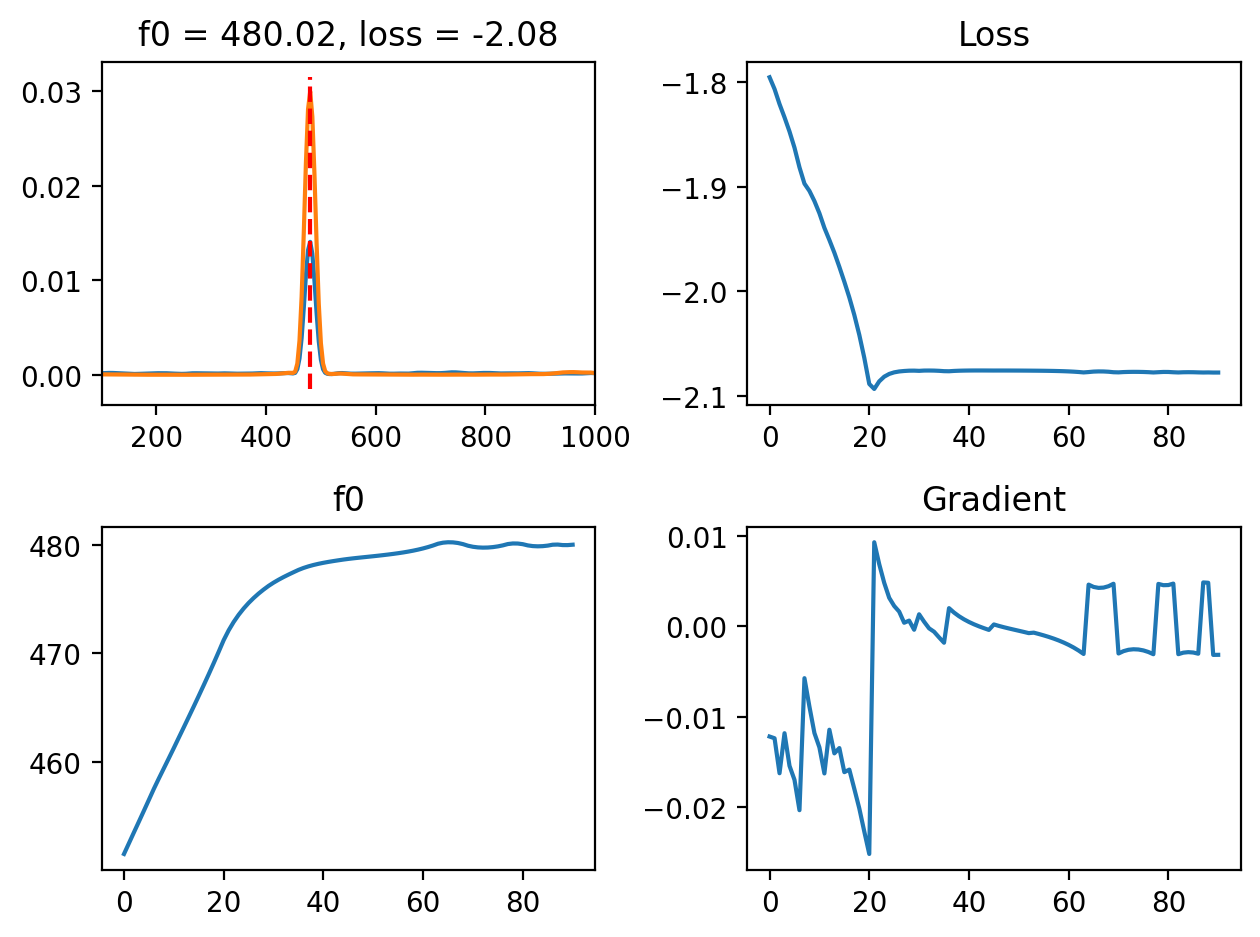

100%|██████████| 100/100 [00:04<00:00, 22.44it/s]


In [22]:
import torch.optim as optim

# Model to use
# comb = combnet.filters.fractional_comb_fiir
# comb = combnet.filters.fractional_comb_fir_multitap
# comb = combnet.filters.fractional_comb_fir_multitap_pseudo_sparse
# comb = combnet.filters.fractional_comb_fir_multitap_sparse
# comb = combnet.filters.fractional_comb_fir_multitap_sparse_lowmem
# comb = combnet.filters.fractional_comb_fir_multitap_sparse_lowmem_convloop
# comb = combnet.filters.single_fractional_comb_fir_lerp
# comb = combnet.filters.single_fractional_comb_fir_multitap_lerp
# comb = combnet.filters.fractional_comb_fir_multitap_lerp
# comb = combnet.filters.fractional_comb_fir_multitap_lerp_explicit
comb = combnet.filters.fractional_comb_fir_multitap_lerp_explicit_triton

# Input data
sr = 8000
torch.manual_seed(8888)
x = torch.sin( 480*torch.linspace( 0, 2*torch.pi, sr)) + torch.randn( sr)

x = x[None].to(device)

# Optimizer and parameters
f0 = torch.tensor( 450.5, device=device).requires_grad_( True)
opt = torch.optim.Adam( [f0], lr=1)

# Forward/backward pass
# @compile
def train_step( f0, x):
    opt.zero_grad( set_to_none=True)
    y = comb( x, f0, .6, sr).squeeze()
    l = -y.std()
    l.backward( retain_graph=True)
    # import pdb; pdb.set_trace()
    opt.step()
    return l.cpu(), y.detach().cpu(), f0.grad.cpu()

# torch.autograd.set_detect_anomaly(False)

# Train
hl,hf,hg = [],[],[]
for j in trange( 100):
    l,y,g = train_step( f0, x)
    hl += [l.item()]
    hf += [f0.item()]
    hg += [g.item()]
    if j%10 == 0:
        gcf().clf()
        gcf().add_subplot( 2, 2, 1, title='Spectra')
        gca().plot( *welch( (x.cpu()/x.cpu().std()).squeeze(), fs=sr, nperseg=512, nfft=2048), label='input')
        gca().plot( *welch( y/y.std(), fs=sr, nperseg=512, nfft=2048), label='response')
        gca().vlines( f0.detach().cpu(), *gca().get_ylim(), color='r', linestyle='--')
        gca().set_xlim( 100, 1000)
        gca().set_title( f'f0 = {f0.item():.2f}, loss = {l.item():.2f}')
        gcf().add_subplot( 2, 2, 3, title='f0').plot( hf)
        gcf().add_subplot( 2, 2, 2, title='Loss').plot( hl)
        gcf().add_subplot( 2, 2, 4, title='Gradient').plot( hg)
        gcf().tight_layout()
        drawnow()

In [140]:
import numpy as np
from tqdm.contrib import tenumerate

x, sr = torchaudio.load('tri.wav')

import os
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
# device = torch.device('mps')
device = torch.device('cuda:0')

x = x.to(device)

# comb_fn = combnet.filters.fractional_comb_fir_multitap
# comb_fn = combnet.filters.fractional_comb_fiir
# comb_fn = combnet.filters.fractional_comb_fir_multitap_sparse
# comb_fn = combnet.filters.fractional_comb_fir_multitap_sparse_lowmem
# comb_fn = combnet.filters.fractional_comb_fir_multitap_lerp
comb_fn = combnet.filters.fractional_comb_fir_multitap_lerp_explicit

def loss(f):
    y = comb_fn( x, f, .7, sr).squeeze()
    return -y.std()

def grad(f):
    f.requires_grad = True
    l = loss(f)
    l.backward()
    g = f.grad.detach().squeeze()
    return -g

# Scan over solutions
print('scanning loss landscape and gradients')
# f = torch.linspace(100, 600, 200)
# f = torch.linspace(200, 600, 200)
f = torch.linspace(400, 600, 100)
# f = torch.linspace(500, 600, 50)
# f = torch.linspace(200, 400, 10)
# f = torch.linspace(360, 380, 20)
l2 = torch.zeros(len(f), len(f))
g_x = torch.zeros(len(f), len(f))
g_y = torch.zeros(len(f), len(f))
for i,f1 in tenumerate( f):
    # for j,f2 in tenumerate(f[i:]):
    for j,f2 in enumerate(f):
        f0 = torch.tensor([[f1], [f2]]).to(device)
        l2[i,j] = loss(f=f0).detach().cpu()
        # l2[i,j+i] = loss(f=f0).detach()
        # l2[j+i,i] = l2[i,j+i]
        g = grad(f=f0).cpu()
        # g_x[i,j+i] = g[0]
        # g_y[i,j+i] = g[1]
        g_x[i,j] = g[0]
        g_y[i,j] = g[1]

# f = f.detach()
# l2 = l2.detach()

# max_val = max(abs(g_x).max(), abs(g_y).max())

# g_x /= max_val
# g_y /= max_val

scanning loss landscape and gradients


[autoreload of combnet.filters failed: Traceback (most recent call last):
  File "/home/cameron/.conda/envs/cameron/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/cameron/.conda/envs/cameron/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/cameron/.conda/envs/cameron/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/cameron/.conda/envs/cameron/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cameron/.conda/envs/cameron/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/cameron/.conda/envs/cameron/lib/python3.11/site-packages/IP

  0%|          | 0/100 [00:00<?, ?it/s]

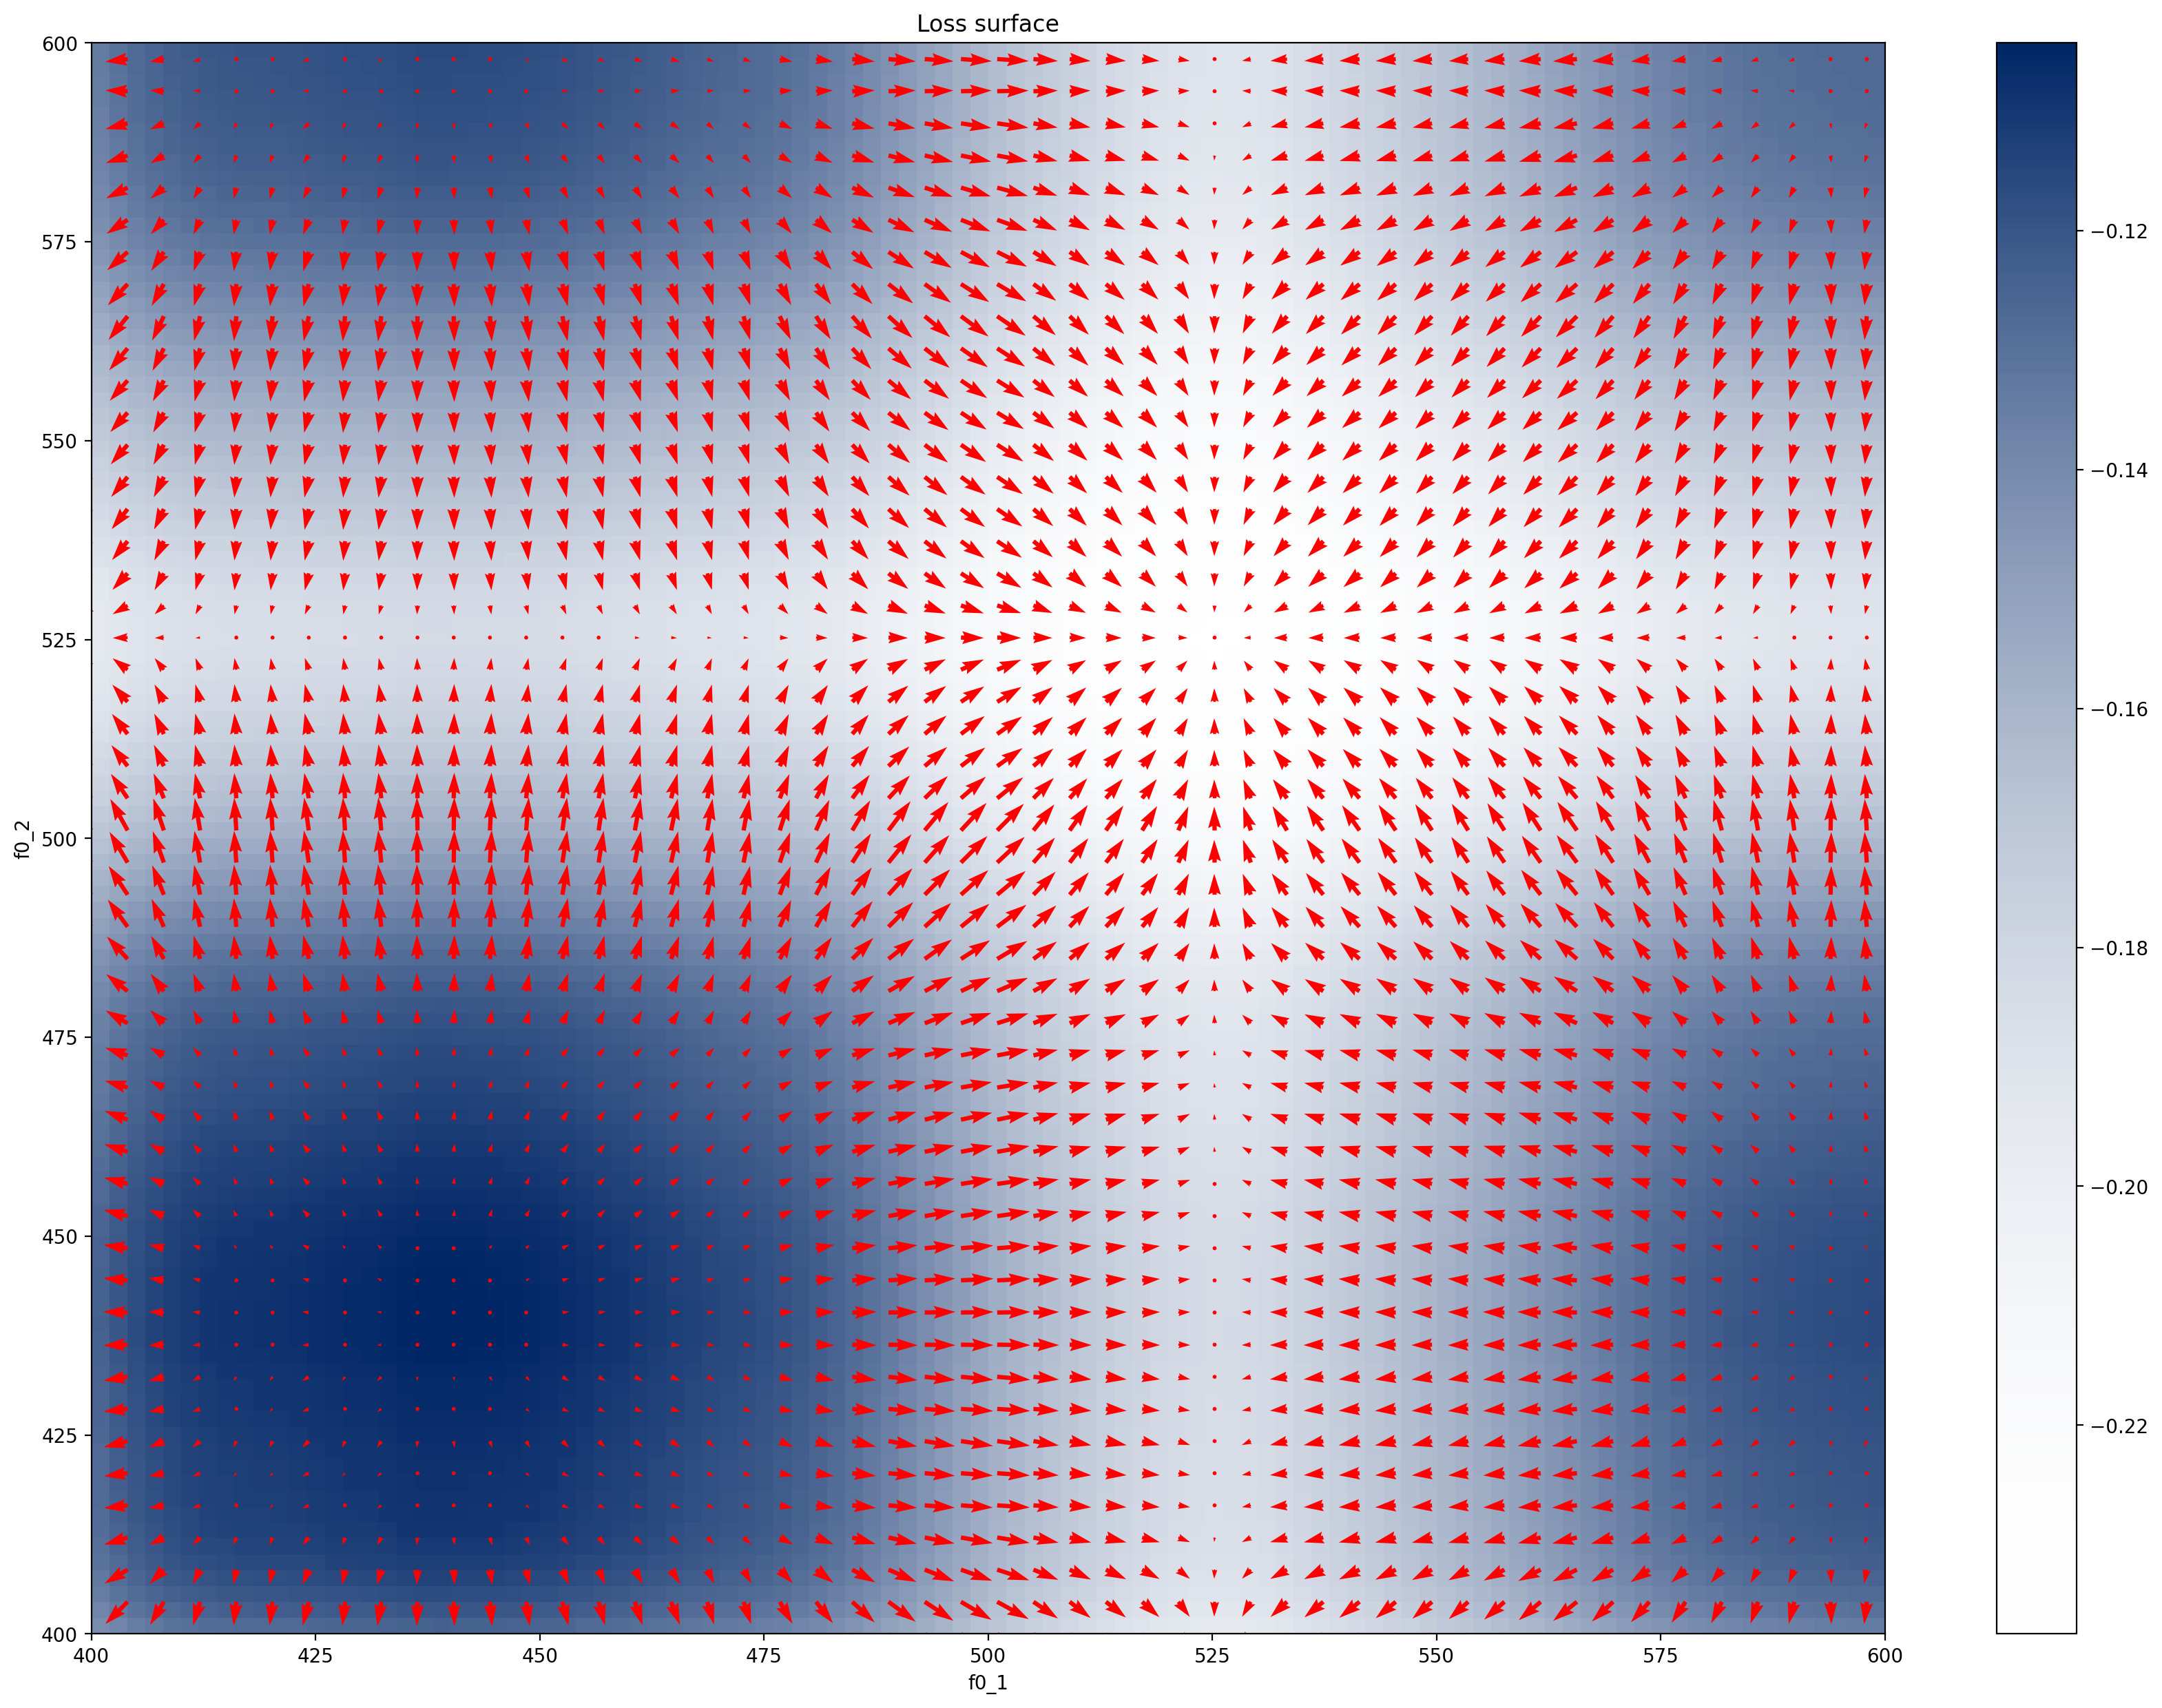

In [142]:
gcf().set_size_inches(21, 15)
x_start = 0
y_start = x_start
gcf().add_subplot(1, 1, 1, xlabel='f0_1', ylabel='f0_2', title=f'Loss surface')
colorbar(gca().pcolorfast(f[x_start:], f[y_start:], l2[x_start:, y_start:]))
arrow_stride = 2
gca().quiver(
    f[x_start::arrow_stride],
    f[y_start::arrow_stride],
    g_y[x_start::arrow_stride, y_start::arrow_stride],
    g_x[x_start::arrow_stride, y_start::arrow_stride],
    color='red')


# gcf().add_subplot(1, 2, 2, xlabel='f0_1', ylabel='f0_2', title=f'Gradient field')

# gca().quiver(f, f, g_x, g_y)

drawnow()

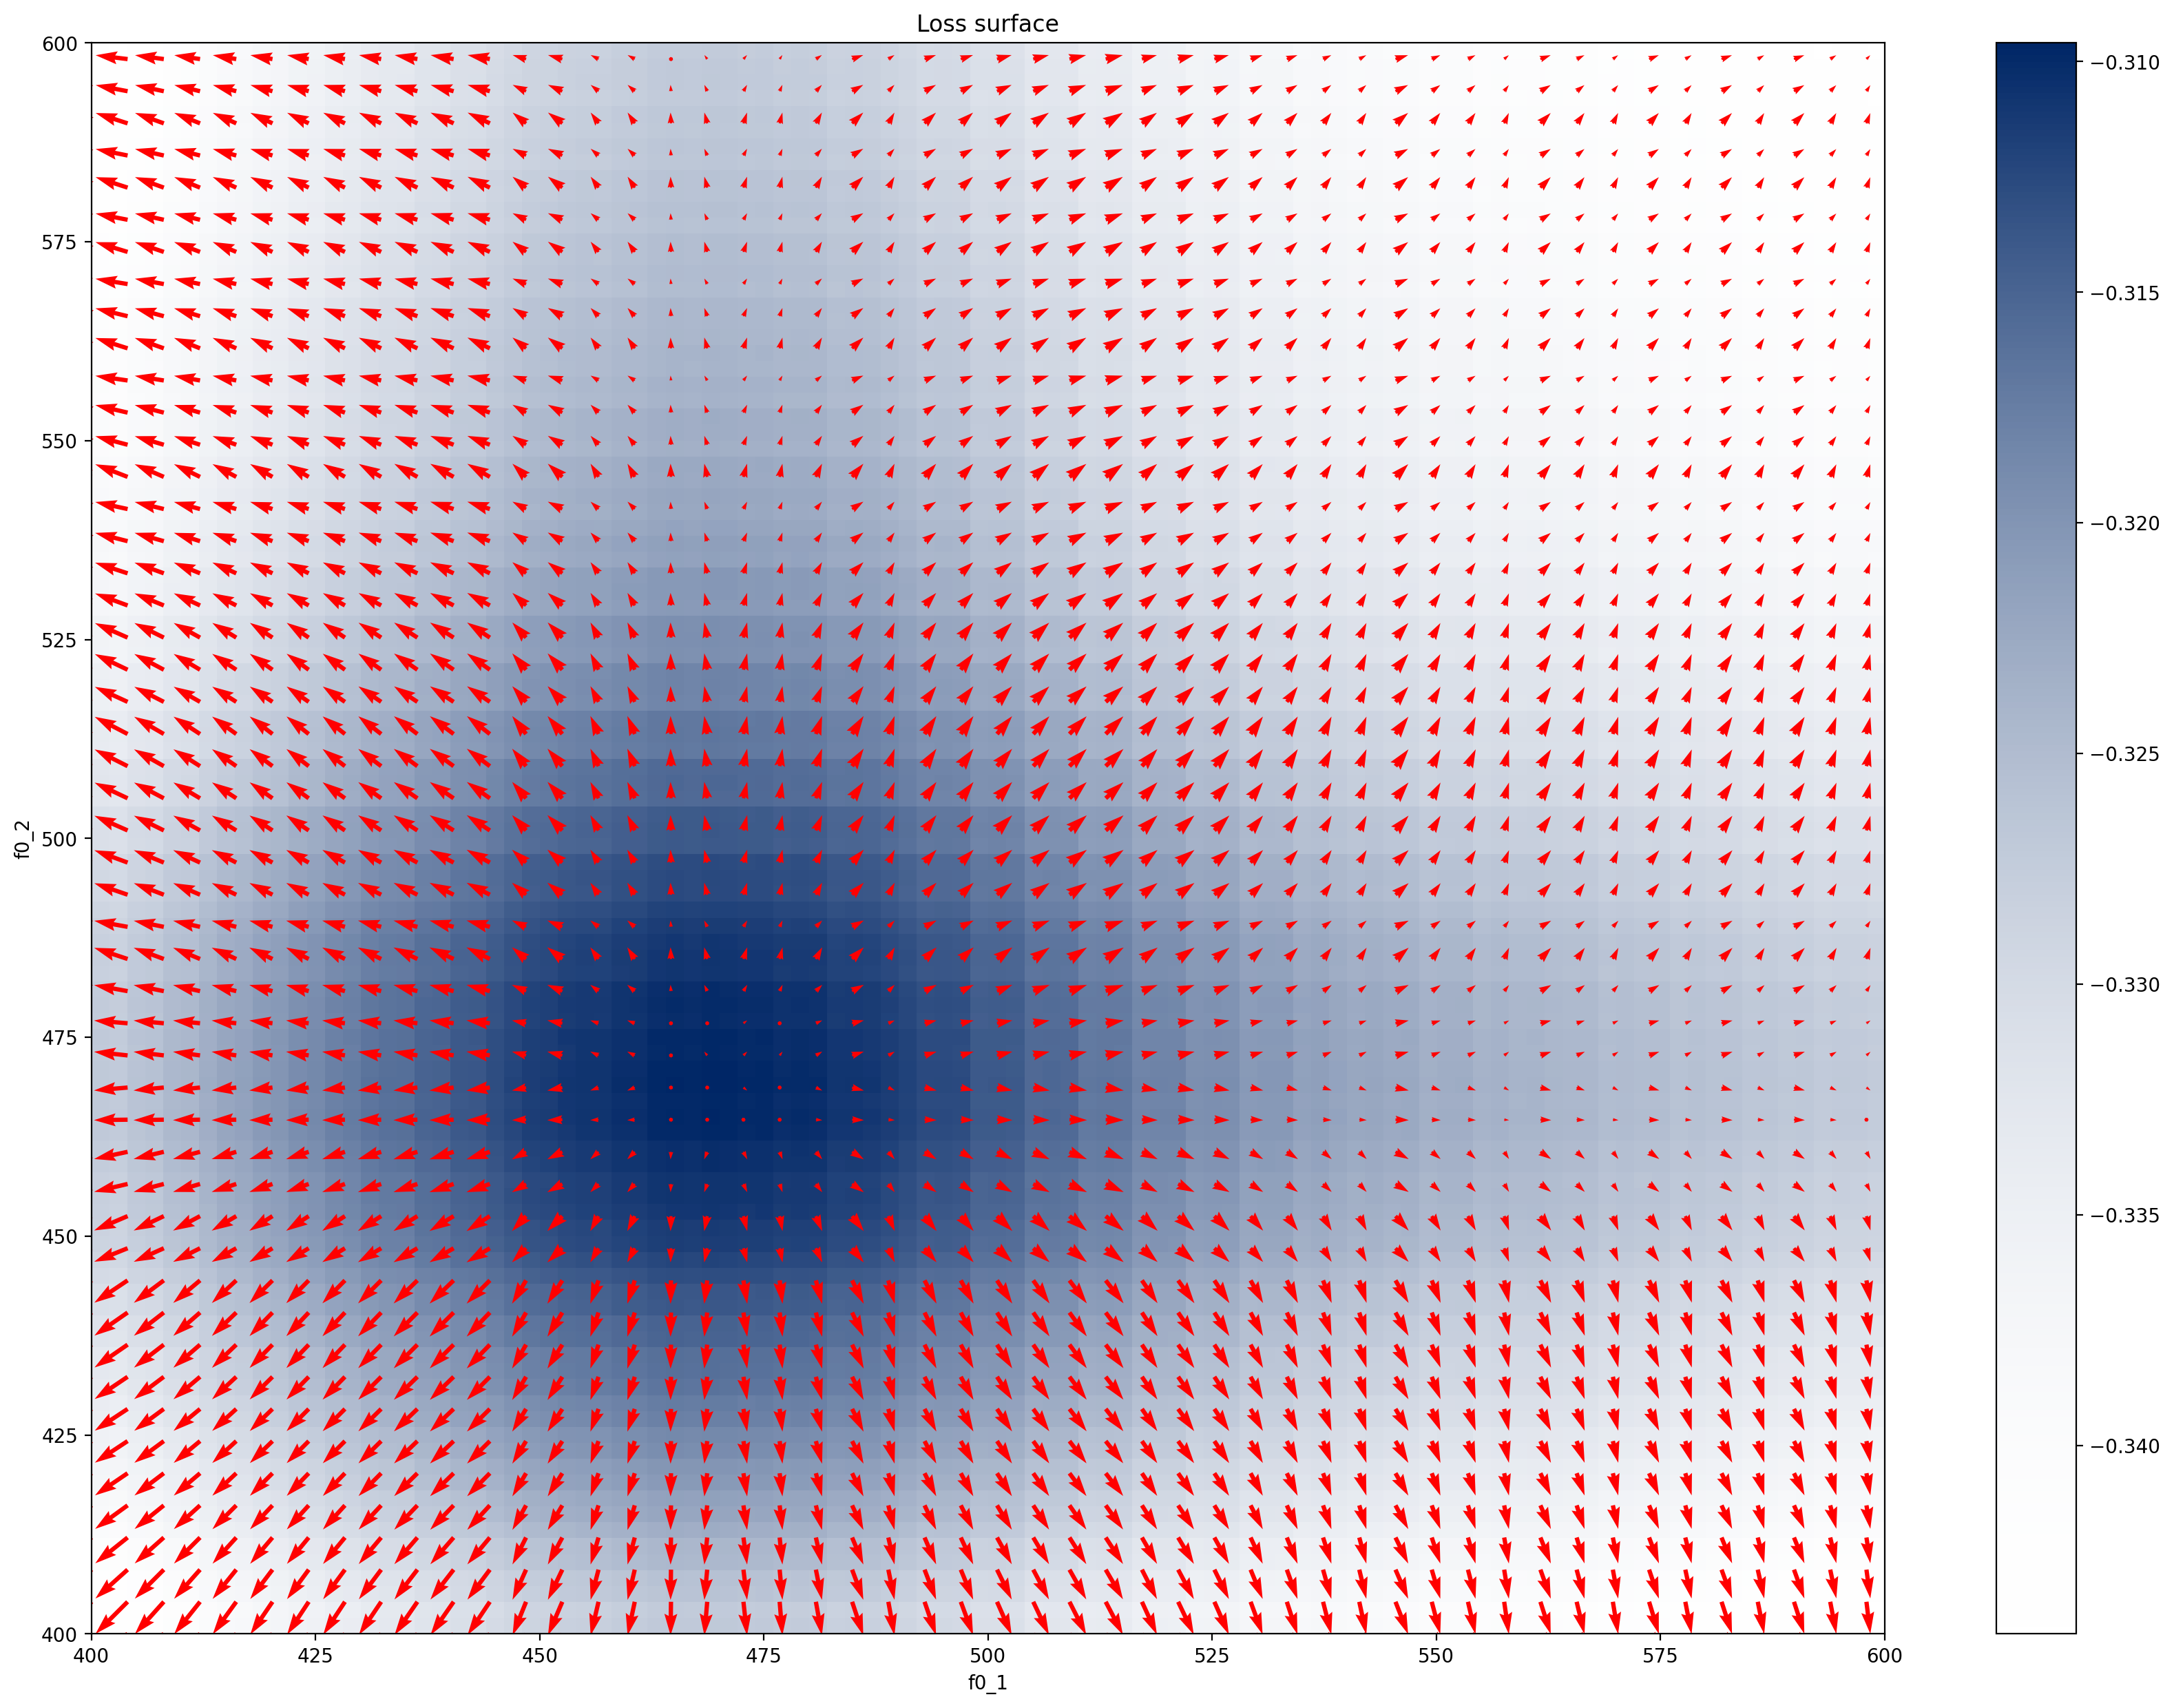

In [41]:
gcf().set_size_inches(21, 15)
x_start = 0
y_start = x_start
gcf().add_subplot(1, 1, 1, xlabel='f0_1', ylabel='f0_2', title=f'Loss surface')
colorbar(gca().pcolorfast(f[x_start:], f[y_start:], l2[x_start:, y_start:]))
arrow_stride = 2
gca().quiver(
    f[x_start::arrow_stride],
    f[y_start::arrow_stride],
    g_y[x_start::arrow_stride, y_start::arrow_stride],
    g_x[x_start::arrow_stride, y_start::arrow_stride],
    color='red')


# gcf().add_subplot(1, 2, 2, xlabel='f0_1', ylabel='f0_2', title=f'Gradient field')

# gca().quiver(f, f, g_x, g_y)

drawnow()

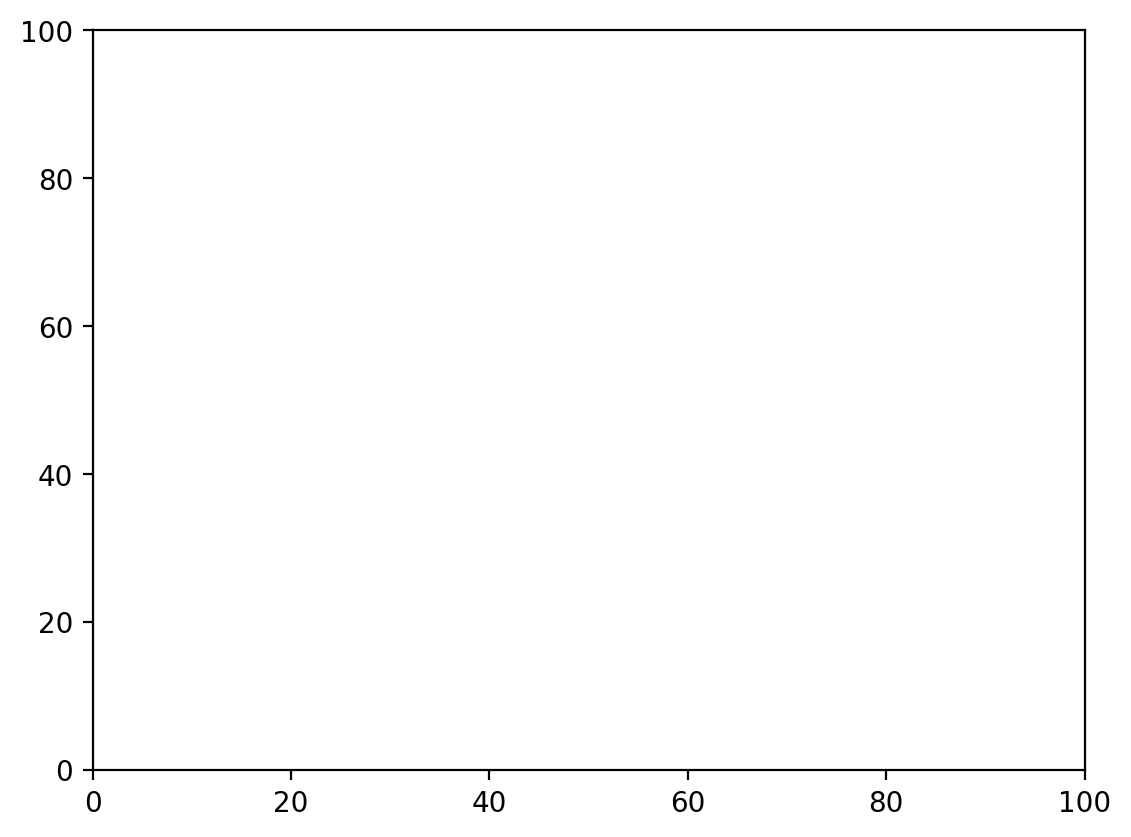

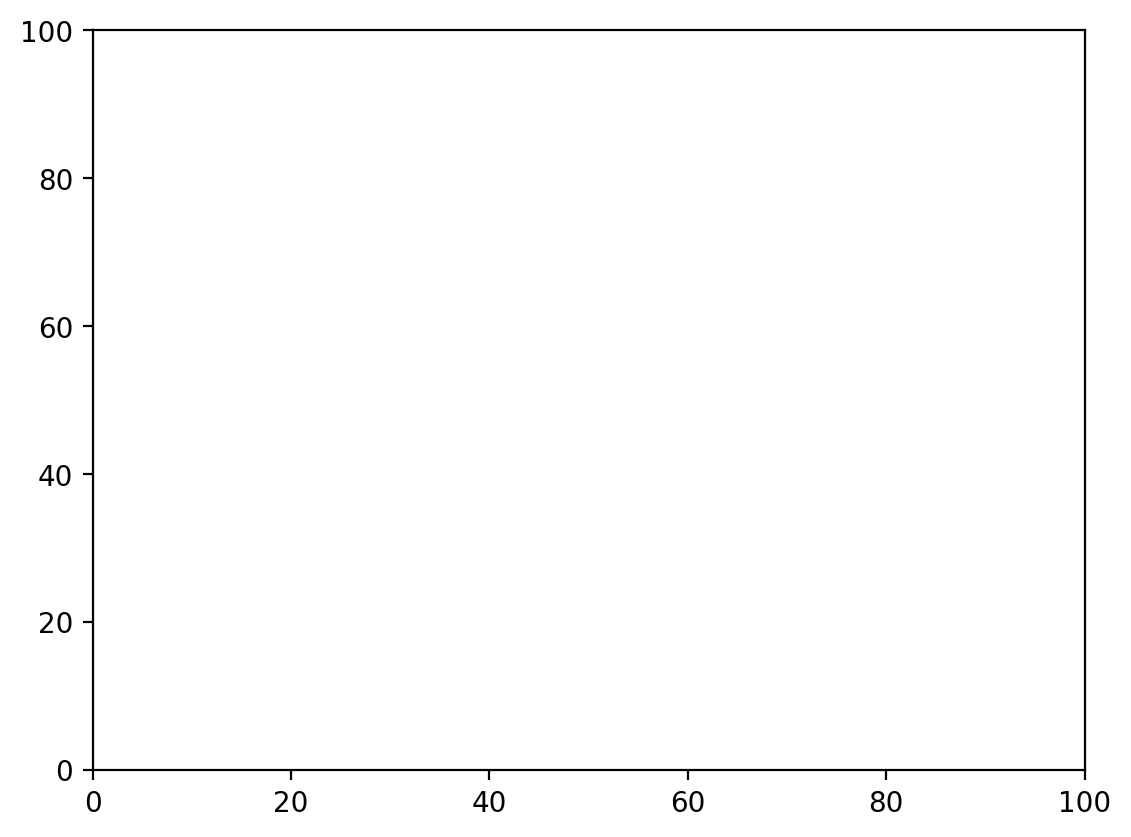

In [5]:
x_nan = torch.where(g_x.isnan(), 1.0, 0.0)
y_nan = torch.where(g_y.isnan(), 1.0, 0.0)
plt.pcolormesh(x_nan); plt.show()
plt.pcolormesh(y_nan); plt.show()

In [6]:
g_x_torch = g_x.clone()
g_y_torch = g_y.clone()

In [16]:
sparse = torch.tensor([
    [
        [1, 0, 2],
        [3, 4, 0],
        [1, 0, 5],
    ],
    [
        [5, 6, 0],
        [7, 0, 8],
        [0, 4, 9],
    ]
])
sparse, sparse.shape

(tensor([[[1, 0, 2],
          [3, 4, 0],
          [1, 0, 5]],
 
         [[5, 6, 0],
          [7, 0, 8],
          [0, 4, 9]]]),
 torch.Size([2, 3, 3]))

In [19]:
sparse[sparse>0].reshape(2, 3, 2)

tensor([[[1, 2],
         [3, 4],
         [1, 5]],

        [[5, 6],
         [7, 8],
         [4, 9]]])